# Capstone Project: Barclays Premier League Predictions


# Part 5 - Predictions & Conclusion

In this notebook, we will attempt to make predictions using models that we have built. We will compare our predictions to the odds from Singapore Pools. 

First, we will use the latest season dataset, which is fixtures for 2020/2021. Then, we will add the upcoming matches into the dataset. After that, we will go through the same feature engineering and cleaning methods same as in Notebook Part 2. We will be using the models saved in the pickle to predict the result. After that, we will convert the probabilities to odds and compare them with Singapore Pools' set of odds.

## Importing Modules, Functions & Datasets

In [1]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image

pd.set_option('max_rows',None)
pd.set_option('max_columns',None)

In [2]:
#functions built for this notebook
def first_clean(df):
    '''
    Description: First part of cleaning of dataset such as removal of non-players row. 
                 Remove features that are repeated.
                 Change attendance format
    Input:
        - dataset
    Output: 
        - dataset
    '''
    #Name error on Brighton & Hove Albion
    df['Home'] = df['Home'].str.replace('Brighton &amp; Hove Albion','Brighton & Hove Albion')
    df['Away'] = df['Away'].str.replace('Brighton &amp; Hove Albion','Brighton & Hove Albion')
    df['Match'] = df['Match'].str.replace('Brighton_&amp;_Hove_Albion','Brighton_&_Hove_Albion')
    
    df.drop(df.loc[df['Player'].str.contains('Players')].index,inplace=True)
    df.drop(columns=['Won%','Cmp%','Int_y'],inplace=True)
    df.Attendance= df.Attendance.str.replace(',','')
    
    return df

def create_fixtures(df):
    '''Grouping the fixtures in terms of date, matches, teams, stadium and attendance. 
    Players match stats will be summed into team level.'''

    combined_df_new = df.groupby(['Date','Match','Home','Away','Stadium','Attendance'],sort=False,as_index=False)['Gls', 'Ast', 'PK', 'PKatt',
           'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Press', 'Tkl', 'Int_x',
           'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA', 'Cmp', 'Att', 'Prog',
           'Carries', 'Prog.1', 'Succ', 'Att.1', 'Home', 'Away', 'Match', 'Date',
           'Stadium', 'Attendance', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs','TklW', 
            'PKwon', 'PKcon', 'OG', 'Recov', 'Won', 'Lost'].sum()
    
    combined_df_new.drop_duplicates(inplace=True)
    
    for x in range(len(combined_df_new.Stadium)):
        if combined_df_new['Attendance'][x].isnumeric() == False:
            combined_df_new['Stadium'][x] = combined_df_new['Attendance'][x]
            combined_df_new['Attendance'][x] = 0
    
    return combined_df_new

def combine_fixtures(df_list):
    '''
    Description: Combine all fixtures datasets together and sort them by 'date','match','home' and 'away'
    
    Input:
        - dataset
    Output: 
        - combined_fixtures dataset
        
    '''
    combined_fixtures = pd.concat(df_list,axis=0,ignore_index=True)
    combined_fixtures['Date'] = pd.to_datetime(combined_fixtures['Date'])
    combined_fixtures = combined_fixtures.sort_values(['Date','Match','Home','Away'])
    
    return combined_fixtures

#function to create last 5 games and last 3 games stats
def average_last_5_stats(features,df):
    '''
    Description: Its picks a variable(str) and generates the 5 last games mean of this variable until the last game played.
    
    Input:
        - Variable (Str)
    Output: 
        - Last 5 games Variable Mean until the new game (Int)    
    '''
    #last_5_avg = pd.DataFrame()
    
    for f in features:
        feature = (df.groupby('Home')[f].
                   transform(lambda row: row.rolling(5, min_periods=1).
                             mean()
                             .shift(1))) # Shift the data down 1 so we don't leak data
        
        df["last_5_avrg_"+f] = feature # Add the new feature to the DataFrame

def average_last_3_stats(features,df):
    '''
    Description: Its picks a variable(str) and generates the 3 last games mean of this variable until the last game played.
    
    Input:
        - Variable (Str)
    Output: 
        - Last 3 games Variable Mean until the new game (Int)    
    '''
    #last_3_avg = pd.DataFrame()
    
    for f in features:
        feature = (df.groupby('Home')[f].
                   transform(lambda row: row.rolling(3, min_periods=1).
                             mean()
                             .shift(1))) # Shift the data down 1 so we don't leak data
        
        df["last_3_avrg_"+f] = feature # Add the new feature to the DataFrame
        
def combine_home_away(df):
    '''
    Description: Combine same fixtures into one row
    
    Input:
        - Dataset
    Output: 
        - Dataset with fixtures that are combined accordingly to matches, dates and teams  
    '''
    away = df.iloc[1::2]
    home = df.iloc[::2]
    combined_1 = pd.merge(home,away,how='outer',on = ['Date','Match'])
    
    combined_2 = combined_1.sort_values('Date')
    combined_2.columns = map(str.lower, combined_2.columns)
    combined_2.drop(columns=['away_y','away_x','attendance_y','stadium_y'],inplace= True)

    return combined_2

#all features to be renamed for home and away

def rename_features_home_away(df):
    '''
    Description: Rename all feature for home and away
    
    Input:
        - Dataset
    Output: 
        - Dataset features renamed
    '''
    df = df.sort_values('date')
    new_features =  {'home_x':'home','gls_x':'h_gls','ast_x':'h_ast', 'pk_x':'h_pk',
    'pkatt_x':'h_pkatt', 'sh_x':'h_sh','sot_x':'h_sot', 'crdy_x':'h_yellow', '2crdy_x' : 'h_yellow2',
    'crdr_x':'h_red', 'crs_x':'h_crs', 'touches_x':'h_touches','press_x':'h_press','tkl_x':'h_tkl','int_x_x':'h_int',
    'blocks_x':'h_blk','xg_x':'h_xg','npxg_x':'h_npxg','xa_x':'h_xa','sca_x':'h_sca','gca_x':'h_gca',
    'cmp_x':'h_cmp','att_x':'h_pass_att','prog_x':'h_pass_prog','carries_x':'h_carries','prog.1_x':'h_carries_prog',
    'succ_x':'h_dri_succ','att.1_x':'h_dri_att','fls_x':'h_fls','fld_x':'h_fld','off_x':'h_off', 'crs_x':'h_crs',
    'tklw_x':'h_tklw', 'pkwon_x':'h_pkwon', 'pkcon_x' : 'h_pkcon','og_x':'h_og','recov_x':'h_recov','won_x':'h_aer_won',
    'lost_x':'h_aer_lost',
    #last 5 average stats
    'last_5_avrg_gls_x':'h_last_5_avrg_gls','last_5_avrg_ast_x':'h_last_5_avrg_ast',
    'last_5_avrg_pk_x':'h_last_5_avrg_pk','last_5_avrg_pkatt_x':'h_last_5_avrg_pkatt','last_5_avrg_sh_x':'h_last_5_avrg_sh',
    'last_5_avrg_sot_x': 'h_last_5_avrg_sot','last_5_avrg_crdy_x':'h_last_5_avrg_yellow','last_5_avrg_crdr_x':'h_last_5_avrg_red',
    'last_5_avrg_touches_x':'h_last_5_touches','last_5_avrg_press_x':'h_last_5_avrg_press','last_5_avrg_tkl_x':'h_last_5_avrg_tkl',
    'last_5_avrg_int_x_x':'h_last_5_avrg_int','last_5_avrg_blocks_x':'h_last_5_avrg_blk','last_5_avrg_xg_x':'h_last_5_avrg_xg',
    'last_5_avrg_npxg_x':'h_last_5_avrg_npxg','last_5_avrg_xa_x':'h_last_5_avrg_xa','last_5_avrg_sca_x':'h_last_5_avrg_sca',
    'last_5_avrg_gca_x':'h_last_5_avrg_gca','last_5_avrg_cmp_x':'h_last_5_avrg_cmp','last_5_avrg_att_x':'h_last_5_avrg_pass_att',
    'last_5_avrg_prog_x':'h_last_5_avrg_pass_prog','last_5_avrg_carries_x':'h_last_5_avrg_carries','last_5_avrg_prog.1_x':'h_last_5_avrg_carries_prog',
    'last_5_avrg_succ_x':'h_last_5_avrg_dri_succ','last_5_avrg_att.1_x':'h_last_5_avrg_dri_att','last_5_avrg_2crdy_x':'h_last_5_avrg_yellow2',
    'last_5_avrg_fls_x':'h_last_5_avrg_fls','last_5_avrg_fld_x':'h_last_5_avrg_fld','last_5_avrg_off_x':'h_last_5_avrg_off',
    'last_5_avrg_crs_x':'h_last_5_avrg_crs','last_5_avrg_tklw_x':'h_last_5_avrg_tklw','last_5_avrg_pkwon_x':'h_last_5_avrg_pkwon',
    'last_5_avrg_pkcon_x':'h_last_5_avrg_pkcon', 'last_5_avrg_og_x': 'h_last_5_avrg_og', 'last_5_avrg_recov_x':'h_last_5_avrg_recov',
    'last_5_avrg_won_x':'h_last_5_avrg_aer_won','last_5_avrg_lost_x':'h_last_5_avrg_aer_lost',
    #last 3 average stats
    'last_3_avrg_gls_x':'h_last_3_avrg_gls','last_3_avrg_ast_x':'h_last_3_avrg_ast',
    'last_3_avrg_pk_x':'h_last_3_avrg_pk','last_3_avrg_pkatt_x':'h_last_3_avrg_pkatt','last_3_avrg_sh_x':'h_last_3_avrg_sh',
    'last_3_avrg_sot_x': 'h_last_3_avrg_sot','last_3_avrg_crdy_x':'h_last_3_avrg_yellow','last_3_avrg_crdr_x':'h_last_3_avrg_red',
    'last_3_avrg_touches_x':'h_last_3_touches','last_3_avrg_press_x':'h_last_3_avrg_press','last_3_avrg_tkl_x':'h_last_3_avrg_tkl',
    'last_3_avrg_int_x_x':'h_last_3_avrg_int','last_3_avrg_blocks_x':'h_last_3_avrg_blk','last_3_avrg_xg_x':'h_last_3_avrg_xg',
    'last_3_avrg_npxg_x':'h_last_3_avrg_npxg','last_3_avrg_xa_x':'h_last_3_avrg_xa','last_3_avrg_sca_x':'h_last_3_avrg_sca',
    'last_3_avrg_gca_x':'h_last_3_avrg_gca','last_3_avrg_cmp_x':'h_last_3_avrg_cmp','last_3_avrg_att_x':'h_last_3_avrg_pass_att',
    'last_3_avrg_prog_x':'h_last_3_avrg_pass_prog','last_3_avrg_carries_x':'h_last_3_avrg_carries','last_3_avrg_prog.1_x':'h_last_3_avrg_carries_prog',
    'last_3_avrg_succ_x':'h_last_3_avrg_dri_succ','last_3_avrg_att.1_x':'h_last_3_avrg_dri_att','last_3_avrg_2crdy_x':'h_last_3_avrg_yellow2',
    'last_3_avrg_fls_x':'h_last_3_avrg_fls','last_3_avrg_fld_x':'h_last_3_avrg_fld','last_3_avrg_off_x':'h_last_3_avrg_off',
    'last_3_avrg_crs_x':'h_last_3_avrg_crs','last_3_avrg_tklw_x':'h_last_3_avrg_tklw','last_3_avrg_pkwon_x':'h_last_3_avrg_pkwon',
    'last_3_avrg_pkcon_x':'h_last_3_avrg_pkcon', 'last_3_avrg_og_x': 'h_last_3_avrg_og', 'last_3_avrg_recov_x':'h_last_3_avrg_recov',
    'last_3_avrg_won_x':'h_last_3_avrg_aer_won','last_3_avrg_lost_x':'h_last_3_avrg_aer_lost',
    #away features
    'home_y':'away','gls_y':'a_gls','ast_y':'a_ast', 'pk_y':'a_pk','pkatt_y':'a_pkatt','sh_y':'a_sh', 
    'sot_y':'a_sot','crdy_y':'a_yellow', '2crdy_y' : 'a_yellow2','crdr_y':'a_red', 'crs_y':'a_crs', 'touches_y':'a_touches',
    'press_y':'a_press','tkl_y':'a_tkl','int_x_y':'a_int','blocks_y':'a_blk','xg_y':'a_xg','npxg_y':'a_npxg','xa_y':'a_xa',
    'sca_y':'a_sca','gca_y':'a_gca', 'cmp_y':'a_cmp','att_y':'a_pass_att','prog_y':'a_pass_prog','carries_y':'a_carries',
    'prog.1_y':'a_carries_prog','succ_y':'a_dri_succ','att.1_y':'a_dri_att','fls_y':'a_fls','fld_y':'a_fld','off_y':'a_off', 
    'crs_y':'a_crs','tklw_y':'a_tklw', 'pkwon_y':'a_pwon', 'pkcon_y' : 'a_pkcon','og_y':'a_og','recov_y':'a_recov','won_y':'a_aer_won',
    'lost_y':'a_aer_lost','attendance_x':'attendance','stadium_x':'stadium',
    #last 5 average stats
    'last_5_avrg_gls_y':'a_last_5_avrg_gls',
    'last_5_avrg_ast_y':'a_last_5_avrg_ast', 'last_5_avrg_pk_y':'a_last_5_avrg_pk','last_5_avrg_pkatt_y':'a_last_5_avrg_pkatt',
    'last_5_avrg_sh_y':'a_last_5_avrg_sh', 'last_5_avrg_sot_y': 'a_last_5_avrg_sot','last_5_avrg_crdy_y':'a_last_5_avrg_yellow',
    'last_5_avrg_crdr_y':'a_last_5_avrg_red','last_5_avrg_touches_y':'a_last_5_touches','last_5_avrg_press_y':'a_last_5_avrg_press',
    'last_5_avrg_tkl_y':'a_last_5_avrg_tkl','last_5_avrg_int_x_y':'a_last_5_avrg_int','last_5_avrg_blocks_y':'a_last_5_avrg_blk',
    'last_5_avrg_xg_y':'a_last_5_avrg_xg','last_5_avrg_npxg_y':'a_last_5_avrg_npxg','last_5_avrg_xa_y':'a_last_5_avrg_xa','last_5_avrg_sca_y':'a_last_5_avrg_sca',       
    'last_5_avrg_gca_y':'a_last_5_avrg_gca', 'last_5_avrg_cmp_y':'a_last_5_avrg_cmp','last_5_avrg_att_y':'a_last_5_avrg_pass_att',
    'last_5_avrg_prog_y':'a_last_5_avrg_pass_prog','last_5_avrg_carries_y':'a_last_5_avrg_carries','last_5_avrg_prog.1_y':'a_last_5_avrg_carries_prog',
    'last_5_avrg_succ_y':'a_last_5_avrg_dri_succ','last_5_avrg_att.1_y':'a_last_5_avrg_dri_att','last_5_avrg_2crdy_y':'a_last_5_avrg_yellow2',
    'last_5_avrg_fls_y':'a_last_5_avrg_fls','last_5_avrg_fld_y':'a_last_5_avrg_fld','last_5_avrg_off_y':'a_last_5_avrg_off',
    'last_5_avrg_crs_y':'a_last_5_avrg_crs','last_5_avrg_tklw_y':'a_last_5_avrg_tklw','last_5_avrg_pkwon_y':'a_last_5_avrg_pkwon',
    'last_5_avrg_pkcon_y':'a_last_5_avrg_pkcon', 'last_5_avrg_og_y': 'a_last_5_avrg_og', 'last_5_avrg_recov_y':'a_last_5_avrg_recov',
    'last_5_avrg_won_y':'a_last_5_avrg_aer_won','last_5_avrg_lost_y':'a_last_5_avrg_aer_lost',
    #last 3 average stats               
    'last_3_avrg_gls_y':'a_last_3_avrg_gls','last_3_avrg_fls_y':'a_last_3_avrg_fls',
    'last_3_avrg_ast_y':'a_last_3_avrg_ast', 'last_3_avrg_pk_y':'a_last_3_avrg_pk','last_3_avrg_pkatt_y':'a_last_3_avrg_pkatt',
    'last_3_avrg_sh_y':'a_last_3_avrg_sh', 'last_3_avrg_sot_y': 'a_last_3_avrg_sot','last_3_avrg_crdy_y':'a_last_3_avrg_yellow',
    'last_3_avrg_crdr_y':'a_last_3_avrg_red','last_3_avrg_touches_y':'a_last_3_touches','last_3_avrg_press_y':'a_last_3_avrg_press',
    'last_3_avrg_tkl_y':'a_last_3_avrg_tkl','last_3_avrg_int_x_y':'a_last_3_avrg_int','last_3_avrg_blocks_y':'a_last_3_avrg_blk',
    'last_3_avrg_xg_y':'a_last_3_avrg_xg','last_3_avrg_npxg_y':'a_last_3_avrg_npxg','last_3_avrg_xa_y':'a_last_3_avrg_xa','last_3_avrg_sca_y':'a_last_3_avrg_sca',       
    'last_3_avrg_gca_y':'a_last_3_avrg_gca', 'last_3_avrg_cmp_y':'a_last_3_avrg_cmp','last_3_avrg_att_y':'a_last_3_avrg_pass_att',
    'last_3_avrg_prog_y':'a_last_3_avrg_pass_prog','last_3_avrg_carries_y':'a_last_3_avrg_carries','last_3_avrg_prog.1_y':'a_last_3_avrg_carries_prog',
    'last_3_avrg_succ_y':'a_last_3_avrg_dri_succ','last_3_avrg_att.1_y':'a_last_3_avrg_dri_att','last_3_avrg_2crdy_y':'a_last_3_avrg_yellow2',
    'lasbt_3_avrg_fls_y':'a_last_3_avrg_fls','last_3_avrg_fld_y':'a_last_3_avrg_fld','last_3_avrg_off_y':'a_last_3_avrg_off',
    'last_3_avrg_crs_y':'a_last_3_avrg_crs','last_3_avrg_tklw_y':'a_last_3_avrg_tklw','last_3_avrg_pkwon_y':'a_last_3_avrg_pkwon',
    'last_3_avrg_pkcon_y':'a_last_3_avrg_pkcon', 'last_3_avrg_og_y': 'a_last_3_avrg_og', 'last_3_avrg_recov_y':'a_last_3_avrg_recov',
    'last_3_avrg_won_y':'a_last_3_avrg_aer_won','last_3_avrg_lost_y':'a_last_3_avrg_aer_lost'}

    df.rename(new_features,axis='columns',inplace=True)
    return df

def add_result(df):
    '''
    Description: Add result feature into dataset
    
    Input:
        - Dataset
    Output: 
        - Dataset with result feature 
    '''
    result=[]
    for i in df['match']:
        i = str(i)
        match = df.loc[df["match"]==i]

        for a in list(match.index):
            if match.loc[a]['h_gls'] + match.loc[a]['a_og'] > match.loc[a]['a_gls'] + match.loc[a]['h_og']:
                #test3[test3.index == a]['result'] = 0
                df.loc[a,'result'] = 0
            elif match.loc[a]['h_gls'] + match.loc[a]['a_og'] < match.loc[a]['a_gls'] + match.loc[a]['h_og']:
                #test3[test3.index == a]['result'] = 2
                df.loc[a,'result'] = 2
            else:
                #test3[test3.index == a]['result'] = 1
                df.loc[a,'result'] = 1
                
    df['result'] = df['result'].astype(int)
    df.sort_values(by='date',inplace=True,ignore_index=True)
    return df

def last5_match(team,df):
    '''
    Description: Creating last five games feature for each team & Creating points per week, 3 = win, 1 = draw, 0 = lose
    
    Input:
        - Dataset and teams
    Output: 
        - Dataset with features, last5matches win/lose or draw and accumulated points during the seasons
    '''
    team_new = df.loc[(df['home'] == team) | (df['away'] == team)]
    zipped = zip(team_new['result'][:-1], team_new['home'][:-1],team_new['away'][:-1])
    last5=[]
    last = []
    last5pts = 0
    lastpts = []
    last.insert(0,'N')
    lastpts.insert(0,0)
    for r,h,a in zipped:
        if (r == 0) & (h == team):
            last5.append('W')
            last5pts = last5pts + 3
        elif (r == 0) & (h != team): 
            last5.append('L')
            last5pts = last5pts + 0
        elif (r == 2) & (a == team):
            last5.append('W')
            last5pts = last5pts + 3
        elif (r == 2) & (a != team):
            last5.append('L')
            last5pts = last5pts + 0
        else:
            last5.append('D')
            last5pts = last5pts + 1
        
        
        last6 = (''.join(last5[-5:]))
        #print(last6)
        last.append(last6)
        lastpts.append(last5pts)
        #print(last[-1])  
    #return last
    for n,l,p in zip(list(team_new.index),last,lastpts):
        if df.iloc[n]['home'] == team:
            df.loc[n,'h_last5match'] = l
            df.loc[n,'h_accumulatpts'] = p
        else:
            df.loc[n,'a_last5match'] = l
            df.loc[n,'a_accumulatpts'] = p

def match_goals(df):
    '''
    Description: Creating match goals for each matches by combining goals and own goals for each side, combining new features
    such as home total goals,away total goals and total goals
    
    Input:
        - Dataset
    Output: 
        - Dataset with new features such as home total goals, away total goals and total goals
    '''
    
    h_list = []
    a_list = []
    
    for m in list(df.index):
    
        hg = int(df.iloc[m]['h_gls']) + int(df.iloc[m]['a_og'])
        ag = int(df.iloc[m]['a_gls']) + int(df.iloc[m]['h_og'])
    
        h_list.append(hg)
        a_list.append(ag)
    
    h_list = pd.DataFrame(h_list)
    a_list = pd.DataFrame(a_list)

    df["h_total_goals"] = h_list
    df["a_total_goals"] = a_list
    df['total_goals'] = df['h_total_goals'] + df['a_total_goals']
               
def combine_fixtures_fifa_data(date1,date2,fifa_df,fixtures_data):
    '''
    Description: Combining fixtures and fifa datasets based on season
    
    Input:
        - Season dates, fixture dataset and fifa dataset
    Output: 
        - Combined fixture and fifa dataset based on season
    '''
    fixtures = fixtures_data.loc[(fixtures_data['date']>date1)&(fixtures_data['date']<=date2)]
    home = list(fixtures.home)
    away = list(fixtures.away)
    
    homestats = pd.DataFrame()
    for i in home:
        hs = fifa_df.loc[fifa_df['club'] == i]
        homestats = homestats.append(hs)
        
    awaystats = pd.DataFrame()
    for i in away:
        ast = fifa_df.loc[fifa_df['club'] == i]
        awaystats = awaystats.append(ast)
        
    fixtures_test = pd.merge(fixtures.reset_index(drop=True),homestats.reset_index(drop=True),left_index=True,right_index=True)
    fixtures_final = pd.merge(fixtures_test.reset_index(drop=True),awaystats.reset_index(drop=True),left_index=True,right_index=True)
    fixtures_final.drop(columns=['club_x','club_y'],inplace=True)
    
    #Columns to be renamed
    to_be_renamed = {'total_value_eur_x' : 'h_total_value_eur', 'total_wage_eur_x':'h_total_wage_eur','average_age_x':'h_average_age',
                    'average_height_cm_x' : 'h_average_height_cm','average_weight_kg_x' : 'h_average_weight_kg','average_overall_x':'h_average_overall',
                    'average_potential_x':'h_average_potential','average_internationl_reputation_x':'h_int_rep','average_skill_moves_x':'h_skill_moves',
                    'age_std_x':'h_age_std','height_cm_std_x':'h_height_cm_std','weight_kg_std_x':'h_weight_kg_std','overall_std_x':'h_overall_std',
                    'potential_std_x' :'h_potential_std','international_reputation_std_x':'h_int_repn_std','skills_moves_average_x':'h_skills_moves_std',
                    'total_value_eur_y' : 'a_total_value_eur','total_wage_eur_y':'a_total_wage_eur','average_age_y':'a_average_age',
                    'average_height_cm_y':'a_average_height_cm','average_weight_kg_y':'a_average_weight_kg','average_overall_y':'a_average_overall',
                    'average_potential_y':'a_average_potential','average_internationl_reputation_y':'a_average_int_rep','average_skill_moves_y':'a_average_skill_moves',
                    'age_std_y':'a_age_std','height_cm_std_y':'a_height_cm_std','weight_kg_std_y':'a_weight_kg_std','overall_std_y':'a_overall_std',
                    'potential_std_y':'a_potential_std','international_reputation_std_y':'a_int_rep_std','skills_moves_average_y':'a_skills_moves_std'}
    fixtures_final= fixtures_final.rename(columns=to_be_renamed)
    
    return fixtures_final

In [3]:
#Import pickle files
result_production_model = pickle.load(open('production_model.pkl', 'rb'))
result_scaler = pickle.load(open('scaler.pkl','rb'))
home_goals_production_model = pickle.load(open('home_goals_production_model.pkl', 'rb'))
home_goals_scaler = pickle.load(open('home_goals_scaler.pkl','rb'))
away_goals_scaler = pickle.load(open('away_goals_scaler.pkl','rb'))
away_goals_production_model = pickle.load(open('away_goals_production_model.pkl', 'rb'))


In [4]:
pred_df = pd.read_csv('data/epl2021_prediction/epl2021_predict.csv')
bpl_fifa21 = pd.read_csv('data/clean/bplteamstats2021_clean.csv')

## Cleaning of Prediction Data

Firstly, we will clean and add fixtures to be predicted in this section. The cleaning method will be similar as to how we have clean and feature engineered our original data.

In [5]:
bpl_fifa21.head()

club  total_value_eur  total_wage_eur  average_age  \
0                 Arsenal        285300000         1287000        25.24   
1             Aston Villa        141370000          751000        24.89   
2  Brighton & Hove Albion        124025000          693000        24.94   
3                 Burnley        137700000          776000        27.59   
4                 Chelsea        437500000         1673000        25.18   

   average_height_cm  average_weight_kg  average_overall  average_potential  \
0             182.12              76.35            78.76              83.82   
1             183.00              75.22            74.00              79.00   
2             182.06              76.53            74.18              78.76   
3             182.88              78.06            75.53              77.24   
4             181.94              78.53            81.59              85.59   

   average_internationl_reputation  average_skill_moves  age_std  \
0                             1.94                 3.12     4.22   
1                             1.22                 2.94     2.93   
2                             1.29                 2.65     3.58   
3                             1.12                 2.65     3.37   
4                             2.29                 3.06     4.63   

   height_cm_std  weight_kg_std  overall_std  potential_std  \
0           5.56           5.96         4.45           2.81   
1           5.86           8.80         5.21           3.24   
2           8.79           7.37         4.50           2.99   
3           6.12           6.59         4.50           3.70   
4           6.95           8.46         3.61           2.90   

   international_reputation_std  skills_moves_average  
0                          1.09                  0.86  
1                          0.55                  0.80  
2                          0.59                  1.06  
3                          0.33                  0.79  
4                          0.99                  0.90

In [6]:
pred_df.tail()

Player     #   Nation  Pos     Age  Min  Gls  Ast  PK  PKatt  Sh  \
5423  Kyle Bartley   5.0  eng ENG   CB  29-239   90    0    1   0      0   0   
5424    Semi Ajayi   6.0   ng NGA   CB  27-068   90    1    0   0      0   1   
5425   Dara O'Shea  27.0   ie IRL   RB  21-318   90    0    0   0      0   0   
5426  David Button  25.0  eng ENG   GK  31-324   90    0    0   0      0   0   
5427    13 Players   NaN      NaN  NaN     NaN  990    3    1   2      2  10   

      SoT  CrdY  CrdR  Touches  Press  Tkl  Int_x  Blocks   xG  npxG   xA  \
5423    0     0     0       38     10    1      0       3  0.0   0.0  0.0   
5424    1     1     0       31     15    2      1       2  0.0   0.0  0.0   
5425    0     0     0       57     11    2      3       2  0.0   0.0  0.0   
5426    0     0     0       39      0    0      0       0  0.0   0.0  0.0   
5427    3     1     0      422    171   16      9      27  2.3   0.8  0.3   

      SCA  GCA  Cmp  Att  Cmp%  Prog  Carries  Prog.1  Succ  Att.1  \
5423    1    1   22   24  91.7     0       12       0     0      0   
5424    1    0   16   23  69.6     0       14       1     0      0   
5425    2    1   20   40  50.0     2       12       2     0      1   
5426    0    0   16   37  43.2     0       12       0     0      0   
5427   18    6  194  297  65.3    22      181      24     5      9   

                      Home                     Away  \
5423  West Bromwich Albion  Wolverhampton Wanderers   
5424  West Bromwich Albion  Wolverhampton Wanderers   
5425  West Bromwich Albion  Wolverhampton Wanderers   
5426  West Bromwich Albion  Wolverhampton Wanderers   
5427  West Bromwich Albion  Wolverhampton Wanderers   

                                                Match        Date  \
5423  Wolverhampton_Wanderers_vs_West_Bromwich_Albion  2021-01-16   
5424  Wolverhampton_Wanderers_vs_West_Bromwich_Albion  2021-01-16   
5425  Wolverhampton_Wanderers_vs_West_Bromwich_Albion  2021-01-16   
5426  Wolverhampton_Wanderers_vs_West_Bromwich_Albion  2021-01-16   
5427  Wolverhampton_Wanderers_vs_West_Bromwich_Albion  2021-01-16   

                                                Stadium  \
5423  <span style="display:inline-block">Michael Oli...   
5424  <span style="display:inline-block">Michael Oli...   
5425  <span style="display:inline-block">Michael Oli...   
5426  <span style="display:inline-block">Michael Oli...   
5427  <span style="display:inline-block">Michael Oli...   

                           Attendance  2CrdY  Fls  Fld  Off  Crs  Int_y  TklW  \
5423  Molineux Stadium, Wolverhampton      0    0    0    1    0      0     1   
5424  Molineux Stadium, Wolverhampton      0    4    1    0    0      1     1   
5425  Molineux Stadium, Wolverhampton      0    2    0    0    2      3     2   
5426  Molineux Stadium, Wolverhampton      0    0    0    0    0      0     0   
5427  Molineux Stadium, Wolverhampton      0   21    9    2    7      9     9   

      PKwon  PKcon  OG  Recov  Won  Lost  Won%  
5423      0      0   0      9    5     1  83.3  
5424      0      0   0      7    7     5  58.3  
5425      0      0   0      4    3     7  30.0  
5426      0      0   0      2    0     0   NaN  
5427      2      0   0     75   21    33  38.9

In [8]:
pred_df = first_clean(pred_df)

In [9]:
pred_df = create_fixtures(pred_df)

<ipython-input-2-4444e1efc56a>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  combined_df_new = df.groupby(['Date','Match','Home','Away','Stadium','Attendance'],sort=False,as_index=False)['Gls', 'Ast', 'PK', 'PKatt',
<ipython-input-2-4444e1efc56a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_new['Stadium'][x] = combined_df_new['Attendance'][x]
<ipython-input-2-4444e1efc56a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_new['Attendance'][x] = 0


In [10]:
pred_df.tail()

Date                                            Match  \
365  2020-11-23           Wolverhampton_Wanderers_vs_Southampton   
366  2020-12-27     Wolverhampton_Wanderers_vs_Tottenham_Hotspur   
367  2020-12-27     Wolverhampton_Wanderers_vs_Tottenham_Hotspur   
368  2021-01-16  Wolverhampton_Wanderers_vs_West_Bromwich_Albion   
369  2021-01-16  Wolverhampton_Wanderers_vs_West_Bromwich_Albion   

                        Home                     Away  \
365              Southampton  Wolverhampton Wanderers   
366  Wolverhampton Wanderers        Tottenham Hotspur   
367        Tottenham Hotspur  Wolverhampton Wanderers   
368  Wolverhampton Wanderers     West Bromwich Albion   
369     West Bromwich Albion  Wolverhampton Wanderers   

                            Stadium Attendance  Gls  Ast  PK  PKatt  Sh  SoT  \
365  Molineux Stadium Wolverhampton          0    1    1   0      0   7    2   
366  Molineux Stadium Wolverhampton          0    1    1   0      0  11    6   
367  Molineux Stadium Wolverhampton          0    1    1   0      0   7    3   
368  Molineux Stadium Wolverhampton          0    2    1   0      0  24    7   
369  Molineux Stadium Wolverhampton          0    3    1   2      2  10    3   

     CrdY  CrdR  Touches  Press  Tkl  Int_x  Blocks   xG  npxG   xA  SCA  GCA  \
365     0     0      660    129   18      6      24  1.5   1.5  1.5   13    2   
366     4     0      694    132   21      8      14  0.9   0.9  0.7   18    2   
367     1     0      600    113   11     22      13  0.4   0.4  0.4   12    1   
368     2     0      710     99   12      9      11  2.2   2.2  1.6   36    1   
369     1     0      422    171   16      9      27  2.2   0.6  0.1   18    6   

     Cmp  Att  Prog  Carries  Prog.1  Succ  Att.1  2CrdY  Fls  Fld  Off  Crs  \
365  441  543    29      376      45    11     22      0   17   17    1   11   
366  478  586    39      468      61    17     25      0   24   16    2   23   
367  377  471    32      381      32     9     13      0   16   24    0    7   
368  494  600    43      421      71    20     27      0   10   21    0   16   
369  194  297    22      181      24     5      9      0   21    9    2    7   

     TklW  PKwon  PKcon  OG  Recov  Won  Lost  
365    14      0      0   0     89   15    23  
366    13      0      0   0     94   18    23  
367     7      0      0   0     75   23    18  
368     7      0      2   0     98   33    21  
369     9      2      0   0     75   21    33

In [11]:
pred_df.isnull().sum()

Date          0
Match         0
Home          0
Away          0
Stadium       0
Attendance    0
Gls           0
Ast           0
PK            0
PKatt         0
Sh            0
SoT           0
CrdY          0
CrdR          0
Touches       0
Press         0
Tkl           0
Int_x         0
Blocks        0
xG            0
npxG          0
xA            0
SCA           0
GCA           0
Cmp           0
Att           0
Prog          0
Carries       0
Prog.1        0
Succ          0
Att.1         0
2CrdY         0
Fls           0
Fld           0
Off           0
Crs           0
TklW          0
PKwon         0
PKcon         0
OG            0
Recov         0
Won           0
Lost          0
dtype: int64

In [12]:
pred_df = combine_fixtures([pred_df])

In [13]:
pred_df.tail(50)

Date                                            Match  \
313 2021-01-02                  West_Bromwich_Albion_vs_Arsenal   
312 2021-01-02                  West_Bromwich_Albion_vs_Arsenal   
78  2021-01-03                       Chelsea_vs_Manchester_City   
79  2021-01-03                       Chelsea_vs_Manchester_City   
249 2021-01-03               Newcastle_United_vs_Leicester_City   
248 2021-01-03               Newcastle_United_vs_Leicester_City   
279 2021-01-04                         Southampton_vs_Liverpool   
278 2021-01-04                         Southampton_vs_Liverpool   
60  2021-01-12                     Burnley_vs_Manchester_United   
61  2021-01-12                     Burnley_vs_Manchester_United   
269 2021-01-12             Sheffield_United_vs_Newcastle_United   
268 2021-01-12             Sheffield_United_vs_Newcastle_United   
357 2021-01-12               Wolverhampton_Wanderers_vs_Everton   
356 2021-01-12               Wolverhampton_Wanderers_vs_Everton   
205 2021-01-13        Manchester_City_vs_Brighton_&_Hove_Albion   
204 2021-01-13        Manchester_City_vs_Brighton_&_Hove_Albion   
301 2021-01-13                      Tottenham_Hotspur_vs_Fulham   
300 2021-01-13                      Tottenham_Hotspur_vs_Fulham   
6   2021-01-14                        Arsenal_vs_Crystal_Palace   
7   2021-01-14                        Arsenal_vs_Crystal_Palace   
129 2021-01-16                                Fulham_vs_Chelsea   
128 2021-01-16                                Fulham_vs_Chelsea   
145 2021-01-16           Leeds_United_vs_Brighton_&_Hove_Albion   
144 2021-01-16           Leeds_United_vs_Brighton_&_Hove_Albion   
174 2021-01-16                    Leicester_City_vs_Southampton   
175 2021-01-16                    Leicester_City_vs_Southampton   
335 2021-01-16                       West_Ham_United_vs_Burnley   
334 2021-01-16                       West_Ham_United_vs_Burnley   
369 2021-01-16  Wolverhampton_Wanderers_vs_West_Bromwich_Albion   
368 2021-01-16  Wolverhampton_Wanderers_vs_West_Bromwich_Albion   
188 2021-01-17                   Liverpool_vs_Manchester_United   
189 2021-01-17                   Liverpool_vs_Manchester_United   
209 2021-01-17                Manchester_City_vs_Crystal_Palace   
208 2021-01-17                Manchester_City_vs_Crystal_Palace   
270 2021-01-17            Sheffield_United_vs_Tottenham_Hotspur   
271 2021-01-17            Sheffield_United_vs_Tottenham_Hotspur   
10  2021-01-18                      Arsenal_vs_Newcastle_United   
11  2021-01-18                      Arsenal_vs_Newcastle_United   
167 2021-01-19                        Leicester_City_vs_Chelsea   
166 2021-01-19                        Leicester_City_vs_Chelsea   
347 2021-01-19          West_Ham_United_vs_West_Bromwich_Albion   
346 2021-01-19          West_Ham_United_vs_West_Bromwich_Albion   
136 2021-01-20                      Fulham_vs_Manchester_United   
137 2021-01-20                      Fulham_vs_Manchester_United   
203 2021-01-20                   Manchester_City_vs_Aston_Villa   
202 2021-01-20                   Manchester_City_vs_Aston_Villa   
183 2021-01-21                             Liverpool_vs_Burnley   
182 2021-01-21                             Liverpool_vs_Burnley   
30  2021-01-23                  Aston_Villa_vs_Newcastle_United   
31  2021-01-23                  Aston_Villa_vs_Newcastle_United   

                        Home                     Away  \
313                  Arsenal     West Bromwich Albion   
312     West Bromwich Albion                  Arsenal   
78                   Chelsea          Manchester City   
79           Manchester City                  Chelsea   
249           Leicester City         Newcastle United   
248         Newcastle United           Leicester City   
279                Liverpool              Southampton   
278              Southampton                Liverpool   
60                   Burnley        Manchester United   
61         Manchester 

In [14]:
#Matches to be predicted
#Newcastle Utd vs Leeds United
#Crystal Palace West Ham
#West Brom Vs Manchester City
#Southampton Vs Arsenal
#Burnley vs Aston Villa
#Chelsea vs Wolves
#Brighton vs Fulham
#Manchester United vs Sheffied United
#Eveton vs Leicester City
#Tottenham vs Liverpool
new_matches = [('2021-01-26','Newcastle_United_vs_Leeds_United','Newcastle United','Leeds United',"St.James' Park"),
              ('2021-01-26','Newcastle_United_vs_Leeds_United','Leeds United','Newcastle United',"St.James' Park"),
              ('2021-01-26','Crystal_Palace_vs_West_Ham_United','Crystal Palace','West Ham United','Selhurst Park'),
              ('2021-01-26','Crystal_Palace_vs_West_Ham_United','West Ham United','Crystal Palace','Selhurst Park'),
              ('2021-01-26','West_Bromwich_Albion_vs_Manchester_City','West Bromwich Albion','Manchester City','The Hawthorns'),
              ('2021-01-26','West_Bromwich_Albion_vs_Manchester_City','Manchester City','West Bromwich Albion','The Hawthorns'),
              ('2021-01-26','Southampton_vs_Arsenal','Southampton','Arsenal',"St. Mary's Stadium"),
              ('2021-01-26','Southampton_vs_Arsenal','Arsenal','Southampton',"St. Mary's Stadium"),
              ('2021-01-27','Burnley_vs_Aston_Villa','Burnley','Aston Villa','Turf Moor'),
              ('2021-01-27','Burnley_vs_Aston_Villa','Aston Villa','Burnley','Turf Moor'),
              ('2021-01-27','Chelsea_vs_Wolverhampton_Wanderers','Chelsea','Wolverhampton Wanderers','Stamford Bridge'),
              ('2021-01-27','Chelsea_vs_Wolverhampton_Wanderers','Wolverhampton Wanderers','Chelsea','Stamford Bridge'),
              ('2021-01-27','Brighton_&_Hove_Albion_vs_Fulham','Brighton & Hove Albion','Fulham','The American Express Community Stadium'),
              ('2021-01-27','Brighton_&_Hove_Albion_vs_Fulham','Fulham','Brighton & Hove Albion','The American Express Community Stadium'),
              ('2021-01-27','Manchester_United_vs_Sheffield_United','Manchester United','Sheffield United','Old Trafford'),
              ('2021-01-27','Manchester_United_vs_Sheffield_United','Sheffield United','Manchester United','Old Trafford'),
              ('2021-01-27','Everton_vs_Leicester_City','Everton','Leicester City','Goodison Park'),
              ('2021-01-27','Everton_vs_Leicester_City','Leicester City','Everton','Goodison Park'),
              ('2021-01-28','Tottenham_Hotspur_vs_Liverpool','Tottenham Hotspur','Liverpool','Tottenham Hotspur Stadium'),
              ('2021-01-28','Tottenham_Hotspur_vs_Liverpool','Liverpool','Tottenham Hotspur','Tottenham Hotspur Stadium')]
new_matches_df = pd.DataFrame(new_matches,columns=['Date','Match','Home','Away','Stadium'])

In [15]:
pred_fixtures = pred_df.sort_index(axis=0)
pred_fixtures.tail()

Date                                            Match  \
365 2020-11-23           Wolverhampton_Wanderers_vs_Southampton   
366 2020-12-27     Wolverhampton_Wanderers_vs_Tottenham_Hotspur   
367 2020-12-27     Wolverhampton_Wanderers_vs_Tottenham_Hotspur   
368 2021-01-16  Wolverhampton_Wanderers_vs_West_Bromwich_Albion   
369 2021-01-16  Wolverhampton_Wanderers_vs_West_Bromwich_Albion   

                        Home                     Away  \
365              Southampton  Wolverhampton Wanderers   
366  Wolverhampton Wanderers        Tottenham Hotspur   
367        Tottenham Hotspur  Wolverhampton Wanderers   
368  Wolverhampton Wanderers     West Bromwich Albion   
369     West Bromwich Albion  Wolverhampton Wanderers   

                            Stadium Attendance  Gls  Ast  PK  PKatt  Sh  SoT  \
365  Molineux Stadium Wolverhampton          0    1    1   0      0   7    2   
366  Molineux Stadium Wolverhampton          0    1    1   0      0  11    6   
367  Molineux Stadium Wolverhampton          0    1    1   0      0   7    3   
368  Molineux Stadium Wolverhampton          0    2    1   0      0  24    7   
369  Molineux Stadium Wolverhampton          0    3    1   2      2  10    3   

     CrdY  CrdR  Touches  Press  Tkl  Int_x  Blocks   xG  npxG   xA  SCA  GCA  \
365     0     0      660    129   18      6      24  1.5   1.5  1.5   13    2   
366     4     0      694    132   21      8      14  0.9   0.9  0.7   18    2   
367     1     0      600    113   11     22      13  0.4   0.4  0.4   12    1   
368     2     0      710     99   12      9      11  2.2   2.2  1.6   36    1   
369     1     0      422    171   16      9      27  2.2   0.6  0.1   18    6   

     Cmp  Att  Prog  Carries  Prog.1  Succ  Att.1  2CrdY  Fls  Fld  Off  Crs  \
365  441  543    29      376      45    11     22      0   17   17    1   11   
366  478  586    39      468      61    17     25      0   24   16    2   23   
367  377  471    32      381      32     9     13      0   16   24    0    7   
368  494  600    43      421      71    20     27      0   10   21    0   16   
369  194  297    22      181      24     5      9      0   21    9    2    7   

     TklW  PKwon  PKcon  OG  Recov  Won  Lost  
365    14      0      0   0     89   15    23  
366    13      0      0   0     94   18    23  
367     7      0      0   0     75   23    18  
368     7      0      2   0     98   33    21  
369     9      2      0   0     75   21    33

In [16]:
pred_fixtures = pred_fixtures.append(new_matches_df,ignore_index=True)

In [17]:
pred_fixtures.tail(20)

Date                                    Match  \
370  2021-01-26         Newcastle_United_vs_Leeds_United   
371  2021-01-26         Newcastle_United_vs_Leeds_United   
372  2021-01-26        Crystal_Palace_vs_West_Ham_United   
373  2021-01-26        Crystal_Palace_vs_West_Ham_United   
374  2021-01-26  West_Bromwich_Albion_vs_Manchester_City   
375  2021-01-26  West_Bromwich_Albion_vs_Manchester_City   
376  2021-01-26                   Southampton_vs_Arsenal   
377  2021-01-26                   Southampton_vs_Arsenal   
378  2021-01-27                   Burnley_vs_Aston_Villa   
379  2021-01-27                   Burnley_vs_Aston_Villa   
380  2021-01-27       Chelsea_vs_Wolverhampton_Wanderers   
381  2021-01-27       Chelsea_vs_Wolverhampton_Wanderers   
382  2021-01-27         Brighton_&_Hove_Albion_vs_Fulham   
383  2021-01-27         Brighton_&_Hove_Albion_vs_Fulham   
384  2021-01-27    Manchester_United_vs_Sheffield_United   
385  2021-01-27    Manchester_United_vs_Sheffield_United   
386  2021-01-27                Everton_vs_Leicester_City   
387  2021-01-27                Everton_vs_Leicester_City   
388  2021-01-28           Tottenham_Hotspur_vs_Liverpool   
389  2021-01-28           Tottenham_Hotspur_vs_Liverpool   

                        Home                     Away  \
370         Newcastle United             Leeds United   
371             Leeds United         Newcastle United   
372           Crystal Palace          West Ham United   
373          West Ham United           Crystal Palace   
374     West Bromwich Albion          Manchester City   
375          Manchester City     West Bromwich Albion   
376              Southampton                  Arsenal   
377                  Arsenal              Southampton   
378                  Burnley              Aston Villa   
379              Aston Villa                  Burnley   
380                  Chelsea  Wolverhampton Wanderers   
381  Wolverhampton Wanderers                  Chelsea   
382   Brighton & Hove Albion                   Fulham   
383                   Fulham   Brighton & Hove Albion   
384        Manchester United         Sheffield United   
385         Sheffield United        Manchester United   
386                  Everton           Leicester City   
387           Leicester City                  Everton   
388        Tottenham Hotspur                Liverpool   
389                Liverpool        Tottenham Hotspur   

                                    Stadium Attendance  Gls  Ast  PK  PKatt  \
370                          St.James' Park        NaN  NaN  NaN NaN    NaN   
371                          St.James' Park        NaN  NaN  NaN NaN    NaN   
372                           Selhurst Park        NaN  NaN  NaN NaN    NaN   
373                           Selhurst Park        NaN  NaN  NaN NaN    NaN   
374                           The Hawthorns        NaN  NaN  NaN NaN    NaN   
375                           The Hawthorns        NaN  NaN  NaN NaN    NaN   
376                      St. Mary's Stadium        NaN  NaN  NaN NaN    NaN   
377                      St. Mary's Stadium        NaN  NaN  NaN NaN    NaN   
378                               Turf Moor        NaN  NaN  NaN NaN    NaN   
379                               Turf Moor        NaN  NaN  NaN NaN    NaN   
380                         Stamford Bridge        NaN  NaN  NaN NaN    NaN   
381                         Stamford Bridge        NaN  NaN  NaN NaN    NaN   
382  The American Express Community Stadium        NaN  NaN  NaN NaN    NaN   
383  The American Express Community Stadium        NaN  NaN  NaN NaN    NaN   
384                            Old Trafford        NaN  NaN  NaN NaN    NaN   
385                            Old Trafford        NaN  NaN  NaN NaN    NaN   
386                           Goodison Park        NaN  NaN  NaN NaN    NaN   
387                           Goodison Park        NaN  NaN  NaN NaN    NaN   
388               Tottenham Hotspur Stadium        

In [18]:
pred_fixtures = pred_fixtures.fillna(0)

In [19]:
#Convert date type
pred_fixtures['Date'] = pd.to_datetime(pred_fixtures['Date'])

In [20]:
#match stats
col = ['Gls', 'Ast','PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Press', 'Tkl','Int_x', 'Blocks', 'xG', 'npxG',
       'xA', 'SCA', 'GCA', 'Cmp', 'Att','Prog', 'Carries', 'Prog.1', 'Succ', 'Att.1', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs',
        'TklW', 'PKwon', 'PKcon', 'OG', 'Recov', 'Won','Lost']

#Generating last 5 match stats 
average_last_5_stats(col,pred_fixtures)

#Generating last 3 match stats
average_last_3_stats(col,pred_fixtures)

In [21]:
pred_fixtures

Date                                              Match  \
0   2020-11-08                             Arsenal_vs_Aston_Villa   
1   2020-11-08                             Arsenal_vs_Aston_Villa   
2   2020-12-13                                 Arsenal_vs_Burnley   
3   2020-12-13                                 Arsenal_vs_Burnley   
4   2020-12-26                                 Arsenal_vs_Chelsea   
5   2020-12-26                                 Arsenal_vs_Chelsea   
6   2021-01-14                          Arsenal_vs_Crystal_Palace   
7   2021-01-14                          Arsenal_vs_Crystal_Palace   
8   2020-10-25                          Arsenal_vs_Leicester_City   
9   2020-10-25                          Arsenal_vs_Leicester_City   
10  2021-01-18                        Arsenal_vs_Newcastle_United   
11  2021-01-18                        Arsenal_vs_Newcastle_United   
12  2020-10-04                        Arsenal_vs_Sheffield_United   
13  2020-10-04                        Arsenal_vs_Sheffield_United   
14  2020-12-16                             Arsenal_vs_Southampton   
15  2020-12-16                             Arsenal_vs_Southampton   
16  2020-09-19                         Arsenal_vs_West_Ham_United   
17  2020-09-19                         Arsenal_vs_West_Ham_United   
18  2020-11-29                 Arsenal_vs_Wolverhampton_Wanderers   
19  2020-11-29                 Arsenal_vs_Wolverhampton_Wanderers   
20  2020-11-21              Aston_Villa_vs_Brighton_&_Hove_Albion   
21  2020-11-21              Aston_Villa_vs_Brighton_&_Hove_Albion   
22  2020-12-17                             Aston_Villa_vs_Burnley   
23  2020-12-17                             Aston_Villa_vs_Burnley   
24  2020-12-26                      Aston_Villa_vs_Crystal_Palace   
25  2020-12-26                      Aston_Villa_vs_Crystal_Palace   
26  2020-10-23                        Aston_Villa_vs_Leeds_United   
27  2020-10-23                        Aston_Villa_vs_Leeds_United   
28  2020-10-04                           Aston_Villa_vs_Liverpool   
29  2020-10-04                           Aston_Villa_vs_Liverpool   
30  2021-01-23                    Aston_Villa_vs_Newcastle_United   
31  2021-01-23                    Aston_Villa_vs_Newcastle_United   
32  2020-09-21                    Aston_Villa_vs_Sheffield_United   
33  2020-09-21                    Aston_Villa_vs_Sheffield_United   
34  2020-11-01                         Aston_Villa_vs_Southampton   
35  2020-11-01                         Aston_Villa_vs_Southampton   
36  2020-12-29                  Brighton_&_Hove_Albion_vs_Arsenal   
37  2020-12-29                  Brighton_&_Hove_Albion_vs_Arsenal   
38  2020-11-06                  Brighton_&_Hove_Albion_vs_Burnley   
39  2020-11-06                  Brighton_&_Hove_Albion_vs_Burnley   
40  2020-09-14                  Brighton_&_Hove_Albion_vs_Chelsea   
41  2020-09-14                  Brighton_&_Hove_Albion_vs_Chelsea   
42  2020-11-28                Brighton_&_Hove_Albion_vs_Liverpool   
43  2020-11-28                Brighton_&_Hove_Albion_vs_Liverpool   
44  2020-09-26        Brighton_&_Hove_Albion_vs_Manchester_United   
45  2020-09-26        Brighton_&_Hove_Albion_vs_Manchester_United   
46  2020-12-20         Brighton_&_Hove_Albion_vs_Sheffield_United   
47  2020-12-20         Brighton_&_Hove_Albion_vs_Sheffield_United   
48  2020-12-07              Brighton_&_Hove_Albion_vs_Southampton   
49  2020-12-07              Brighton_&_Hove_Albion_vs_Southampton   
50  2020-10-26     Brighton_&_Hove_Albion_vs_West_Bromwich_Albion   
51  2020-10-26     Brighton_&_Hove_Albion_vs_West_Bromwich_Albion   
52  2021-01-02  Brighton_&_Hove_Albion_vs_Wolverhampton_Wanderers   
53  2021-01-02  Brighton_&_Hove_Albion_vs_Wolverhampton_Wanderers   
54  2020-10-31                                 Burnley_vs_Chelsea   
55  2020-10-31                                 Burnley_vs_Chelsea   
56  2020-11-23                          Burnley_vs_Crystal_Palace   
57  2020

In [22]:
pred_fixtures = combine_home_away(pred_fixtures)

In [23]:
pred_fixtures.sample(10)

date                             match             home_x  \
128 2020-12-26       Sheffield_United_vs_Everton   Sheffield United   
122 2020-11-01       Newcastle_United_vs_Everton   Newcastle United   
130 2020-09-27  Sheffield_United_vs_Leeds_United   Sheffield United   
193 2021-01-27         Everton_vs_Leicester_City            Everton   
40  2020-11-07       Chelsea_vs_Sheffield_United            Chelsea   
36  2020-10-03         Chelsea_vs_Crystal_Palace            Chelsea   
112 2020-10-24      Manchester_United_vs_Chelsea  Manchester United   
35  2020-12-28            Chelsea_vs_Aston_Villa            Chelsea   
129 2020-10-18        Sheffield_United_vs_Fulham   Sheffield United   
8   2020-09-19        Arsenal_vs_West_Ham_United            Arsenal   

                               stadium_x attendance_x  gls_x  ast_x  pk_x  \
128     Bramall Lane Sheffield Yorkshire            0    0.0    0.0   0.0   
122  St. James' Park Newcastle upon Tyne            0    2.0    0.0   1.0   
130     Bramall Lane Sheffield Yorkshire            0    0.0    0.0   0.0   
193                        Goodison Park            0    0.0    0.0   0.0   
40                Stamford Bridge London            0    4.0    4.0   0.0   
36                Stamford Bridge London            0    4.0    1.0   2.0   
112              Old Trafford Manchester            0    0.0    0.0   0.0   
35                Stamford Bridge London            0    1.0    1.0   0.0   
129     Bramall Lane Sheffield Yorkshire            0    1.0    0.0   1.0   
8                Emirates Stadium London            0    2.0    2.0   0.0   

     pkatt_x  sh_x  sot_x  crdy_x  crdr_x  touches_x  press_x  tkl_x  int_x_x  \
128      0.0  10.0    1.0     2.0     0.0      563.0    116.0   25.0     14.0   
122      1.0   9.0    3.0     2.0     0.0      511.0    111.0   18.0      2.0   
130      0.0  13.0    3.0     2.0     0.0      504.0    187.0   23.0      7.0   
193      0.0   0.0    0.0     0.0     0.0        0.0      0.0    0.0      0.0   
40       0.0  20.0    9.0     0.0     0.0      918.0    132.0   22.0      7.0   
36       2.0  15.0    4.0     2.0     0.0      849.0    135.0   16.0     10.0   
112      0.0  14.0    4.0     3.0     0.0      745.0    124.0   16.0     16.0   
35       0.0  16.0    5.0     3.0     0.0      708.0    138.0   19.0     10.0   
129      1.0   9.0    5.0     0.0     0.0      521.0    130.0   13.0      4.0   
8        0.0   6.0    3.0     0.0     0.0      794.0     91.0    6.0      6.0   

     blocks_x  xg_x  npxg_x  xa_x  sca_x  gca_x  cmp_x  att_x  prog_x  \
128      15.0   1.2     1.2   1.2   13.0    0.0  327.0  442.0    28.0   
122      19.0   2.4     1.6   0.6   16.0    3.0  308.0  399.0    15.0   
130      20.0   1.5     1.5   1.6   23.0    0.0  268.0  370.0    29.0   
193       0.0   0.0     0.0   0.0    0.0    0.0    0.0    0.0     0.0   
40       17.0   2.7     2.7   1.9   31.0    6.0  695.0  789.0    47.0   
36       13.0   2.6     1.0   0.8   27.0    4.0  650.0  736.0    35.0   
112      26.0   0.6     0.6   0.6   22.0    0.0  518.0  622.0    33.0   
35       13.0   1.3     1.3   0.6   23.0    2.0  484.0  597.0    39.0   
129      14.0   1.4     0.6   0.5   18.0    2.0  326.0  430.0    27.0   
8        19.0   1.4     1.4   1.3   10.0    4.0  592.0  693.0    43.0   

     carries_x  prog.1_x  succ_x  att.1_x  2crdy_x  fls_x  fld_x  off_x  \
128      318.0      32.0     6.0     11.0      0.0   15.0   13.0    0.0   
122      269.0      23.0     9.0     10.0      0.0   10.0   13.0    1.0   
130      263.0      45.0     8.0     13.0      0.0   19.0    7.0    2.0   
193        0.0       0.0     0.0      0.0      0.0    0.0    0.0    0.0   
40       557.0      53.0     9.0     15.0      0.0    6.0   18.0    1.0   
36       605.0      57.0     5.0     10.0      0.0   18.0   13.0    1.0   
112      458.0      53.0    11.0     18.0      0.0    9.0    7.0    2.0   
35       491.0      62.0     7.0     16.0      0.0   21.0    5.0    1.0   
129      

In [24]:
#Renaming of features
pred_fixtures = rename_features_home_away(pred_fixtures)
pred_fixtures.tail(10)

date                                    match  \
185 2021-01-26         Newcastle_United_vs_Leeds_United   
186 2021-01-26        Crystal_Palace_vs_West_Ham_United   
187 2021-01-26  West_Bromwich_Albion_vs_Manchester_City   
188 2021-01-26                   Southampton_vs_Arsenal   
192 2021-01-27    Manchester_United_vs_Sheffield_United   
191 2021-01-27         Brighton_&_Hove_Albion_vs_Fulham   
193 2021-01-27                Everton_vs_Leicester_City   
189 2021-01-27                   Burnley_vs_Aston_Villa   
190 2021-01-27       Chelsea_vs_Wolverhampton_Wanderers   
194 2021-01-28           Tottenham_Hotspur_vs_Liverpool   

                       home                                 stadium  \
185        Newcastle United                          St.James' Park   
186          Crystal Palace                           Selhurst Park   
187    West Bromwich Albion                           The Hawthorns   
188             Southampton                      St. Mary's Stadium   
192       Manchester United                            Old Trafford   
191  Brighton & Hove Albion  The American Express Community Stadium   
193                 Everton                           Goodison Park   
189                 Burnley                               Turf Moor   
190                 Chelsea                         Stamford Bridge   
194       Tottenham Hotspur               Tottenham Hotspur Stadium   

    attendance  h_gls  h_ast  h_pk  h_pkatt  h_sh  h_sot  h_yellow  h_red  \
185          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
186          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
187          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
188          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
192          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
191          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
193          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
189          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
190          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
194          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   

     h_touches  h_press  h_tkl  h_int  h_blk  h_xg  h_npxg  h_xa  h_sca  \
185        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
186        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
187        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
188        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
192        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
191        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
193        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
189        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
190        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
194        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   

     h_gca  h_cmp  h_pass_att  h_pass_prog  h_carries  h_carries_prog  \
185    0.0    0.0         0.0          0.0        0.0             0.0   
186    0.0    0.0         0.0          0.0        0.0             0.0   
187    0.0    0.0         0.0          0.0        0.0             0.0   
188    0.0    0.0         0.0          0.0        0.0             0.0   
192    0.0    0.0         0.0          0.0        0.0             0.0   
191    0.0    0.0         0.0          0.0        0.0             0.0   
193    0.0    0.0         0.0          0.0        0.0             0.0   
189    0.0    0.0         0.0          0.0        0.0             0.0   
190    0.0    0.0         0.0          0.0        0.0             0.0   
194    0.0    0.0         0.0          0.0        0.0             0.0   

     h_dri_succ  h_dri_att  h_yellow2  h_fls  h_fld  h_off  h_crs  h_tklw  \
185         0.0        

In [25]:
#Add result feature
pred_fixtures = add_result(pred_fixtures)
pred_fixtures

date                                              match  \
0   2020-09-12                                  Fulham_vs_Arsenal   
1   2020-09-12                          Liverpool_vs_Leeds_United   
2   2020-09-12                      Crystal_Palace_vs_Southampton   
3   2020-09-12                West_Ham_United_vs_Newcastle_United   
4   2020-09-13             West_Bromwich_Albion_vs_Leicester_City   
5   2020-09-13                       Tottenham_Hotspur_vs_Everton   
6   2020-09-14        Sheffield_United_vs_Wolverhampton_Wanderers   
7   2020-09-14                  Brighton_&_Hove_Albion_vs_Chelsea   
8   2020-09-19                             Leeds_United_vs_Fulham   
9   2020-09-19                    Everton_vs_West_Bromwich_Albion   
10  2020-09-19                         Arsenal_vs_West_Ham_United   
11  2020-09-19                Manchester_United_vs_Crystal_Palace   
12  2020-09-20                   Southampton_vs_Tottenham_Hotspur   
13  2020-09-20                          Leicester_City_vs_Burnley   
14  2020-09-20         Newcastle_United_vs_Brighton_&_Hove_Albion   
15  2020-09-20                               Chelsea_vs_Liverpool   
16  2020-09-21                    Aston_Villa_vs_Sheffield_United   
17  2020-09-21         Wolverhampton_Wanderers_vs_Manchester_City   
18  2020-09-26                    West_Bromwich_Albion_vs_Chelsea   
19  2020-09-26        Brighton_&_Hove_Albion_vs_Manchester_United   
20  2020-09-26                          Crystal_Palace_vs_Everton   
21  2020-09-26                             Burnley_vs_Southampton   
22  2020-09-27                  Manchester_City_vs_Leicester_City   
23  2020-09-27                   Sheffield_United_vs_Leeds_United   
24  2020-09-27              Tottenham_Hotspur_vs_Newcastle_United   
25  2020-09-27         West_Ham_United_vs_Wolverhampton_Wanderers   
26  2020-09-28                               Liverpool_vs_Arsenal   
27  2020-09-28                              Fulham_vs_Aston_Villa   
28  2020-10-03                  Everton_vs_Brighton_&_Hove_Albion   
29  2020-10-03                          Chelsea_vs_Crystal_Palace   
30  2020-10-03                    Leeds_United_vs_Manchester_City   
31  2020-10-03                        Newcastle_United_vs_Burnley   
32  2020-10-04             Manchester_United_vs_Tottenham_Hotspur   
33  2020-10-04                Southampton_vs_West_Bromwich_Albion   
34  2020-10-04                  Wolverhampton_Wanderers_vs_Fulham   
35  2020-10-04                           Aston_Villa_vs_Liverpool   
36  2020-10-04                  Leicester_City_vs_West_Ham_United   
37  2020-10-04                        Arsenal_vs_Sheffield_United   
38  2020-10-17                               Everton_vs_Liverpool   
39  2020-10-17                             Chelsea_vs_Southampton   
40  2020-10-17              Newcastle_United_vs_Manchester_United   
41  2020-10-17                         Manchester_City_vs_Arsenal   
42  2020-10-18                      Leicester_City_vs_Aston_Villa   
43  2020-10-18           Crystal_Palace_vs_Brighton_&_Hove_Albion   
44  2020-10-18                         Sheffield_United_vs_Fulham   
45  2020-10-18               Tottenham_Hotspur_vs_West_Ham_United   
46  2020-10-19            Leeds_United_vs_Wolverhampton_Wanderers   
47  2020-10-19                    West_Bromwich_Albion_vs_Burnley   
48  2020-10-23                        Aston_Villa_vs_Leeds_United   
49  2020-10-24                       Manchester_United_vs_Chelsea   
50  2020-10-24                           Fulham_vs_Crystal_Palace   
51  2020-10-24                 West_Ham_United_vs_Manchester_City   
52  2020-10-24                      Liverpool_vs_Sheffield_United   
53  2020-10-25                             Southampton_vs_Everton   
54  2020-10-25                          Arsenal_vs_Leicester_City   
55  2020-10-25        Wolverhampton_Wanderers_vs_Newcastle_United   
56  2020-10-26                       Burnley_vs_Tottenham_Hotspur   
57  2020

In [26]:
#Getting list of clubs in the combined dataset
unique_teams = pred_fixtures['home'].unique()
unique_teams


array(['Fulham', 'Liverpool', 'Crystal Palace', 'West Ham United',
       'West Bromwich Albion', 'Tottenham Hotspur', 'Sheffield United',
       'Brighton & Hove Albion', 'Leeds United', 'Everton', 'Arsenal',
       'Manchester United', 'Southampton', 'Leicester City',
       'Newcastle United', 'Chelsea', 'Aston Villa',
       'Wolverhampton Wanderers', 'Burnley', 'Manchester City'],
      dtype=object)

In [27]:
#Creating new features such as last 5 matches win, lose or draw
for team in unique_teams:
    last5_match(team,pred_fixtures)

In [28]:
pred_fixtures.tail(50)

date                                              match  \
145 2020-12-27                            Leeds_United_vs_Burnley   
146 2020-12-27                  Liverpool_vs_West_Bromwich_Albion   
147 2020-12-28                             Chelsea_vs_Aston_Villa   
148 2020-12-28                   Crystal_Palace_vs_Leicester_City   
149 2020-12-29                     Southampton_vs_West_Ham_United   
150 2020-12-29                  Brighton_&_Hove_Albion_vs_Arsenal   
151 2020-12-29                        Burnley_vs_Sheffield_United   
152 2020-12-29       Manchester_United_vs_Wolverhampton_Wanderers   
153 2020-12-29               West_Bromwich_Albion_vs_Leeds_United   
154 2020-12-30                      Newcastle_United_vs_Liverpool   
155 2021-01-01                         Everton_vs_West_Ham_United   
156 2021-01-01                   Manchester_United_vs_Aston_Villa   
157 2021-01-02                    West_Bromwich_Albion_vs_Arsenal   
158 2021-01-02  Brighton_&_Hove_Albion_vs_Wolverhampton_Wanderers   
159 2021-01-02                  Tottenham_Hotspur_vs_Leeds_United   
160 2021-01-02                 Crystal_Palace_vs_Sheffield_United   
161 2021-01-03                         Chelsea_vs_Manchester_City   
162 2021-01-03                 Newcastle_United_vs_Leicester_City   
163 2021-01-04                           Southampton_vs_Liverpool   
164 2021-01-12                       Burnley_vs_Manchester_United   
165 2021-01-12               Sheffield_United_vs_Newcastle_United   
166 2021-01-12                 Wolverhampton_Wanderers_vs_Everton   
167 2021-01-13                        Tottenham_Hotspur_vs_Fulham   
168 2021-01-13          Manchester_City_vs_Brighton_&_Hove_Albion   
169 2021-01-14                          Arsenal_vs_Crystal_Palace   
170 2021-01-16                                  Fulham_vs_Chelsea   
171 2021-01-16             Leeds_United_vs_Brighton_&_Hove_Albion   
172 2021-01-16                      Leicester_City_vs_Southampton   
173 2021-01-16    Wolverhampton_Wanderers_vs_West_Bromwich_Albion   
174 2021-01-16                         West_Ham_United_vs_Burnley   
175 2021-01-17                  Manchester_City_vs_Crystal_Palace   
176 2021-01-17                     Liverpool_vs_Manchester_United   
177 2021-01-17              Sheffield_United_vs_Tottenham_Hotspur   
178 2021-01-18                        Arsenal_vs_Newcastle_United   
179 2021-01-19                          Leicester_City_vs_Chelsea   
180 2021-01-19            West_Ham_United_vs_West_Bromwich_Albion   
181 2021-01-20                        Fulham_vs_Manchester_United   
182 2021-01-20                     Manchester_City_vs_Aston_Villa   
183 2021-01-21                               Liverpool_vs_Burnley   
184 2021-01-23                    Aston_Villa_vs_Newcastle_United   
185 2021-01-26                   Newcastle_United_vs_Leeds_United   
186 2021-01-26                  Crystal_Palace_vs_West_Ham_United   
187 2021-01-26            West_Bromwich_Albion_vs_Manchester_City   
188 2021-01-26                             Southampton_vs_Arsenal   
189 2021-01-27                             Burnley_vs_Aston_Villa   
190 2021-01-27                          Everton_vs_Leicester_City   
191 2021-01-27                 Chelsea_vs_Wolverhampton_Wanderers   
192 2021-01-27              Manchester_United_vs_Sheffield_United   
193 2021-01-27                   Brighton_&_Hove_Albion_vs_Fulham   
194 2021-01-28                     Tottenham_Hotspur_vs_Liverpool   

                        home  \
145             Leeds United   
146                Liverpool   
147                  Chelsea   
148           Crystal Palace   
149              Southampton   
150   Brighton & Hove Albion   
151                  Burnley   
152        Manchester United   
153     West Bromwich Albion   
154         Newcastle United   
155                  Everton   
156        Manchester United   
157     West Bromwich Albion   
158   Brighton & Hove Albion   
159       

In [29]:
#Creating match goals for each row
match_goals(pred_fixtures)

In [30]:
pred_fixtures.tail(40)

date                                              match  \
155 2021-01-01                         Everton_vs_West_Ham_United   
156 2021-01-01                   Manchester_United_vs_Aston_Villa   
157 2021-01-02                    West_Bromwich_Albion_vs_Arsenal   
158 2021-01-02  Brighton_&_Hove_Albion_vs_Wolverhampton_Wanderers   
159 2021-01-02                  Tottenham_Hotspur_vs_Leeds_United   
160 2021-01-02                 Crystal_Palace_vs_Sheffield_United   
161 2021-01-03                         Chelsea_vs_Manchester_City   
162 2021-01-03                 Newcastle_United_vs_Leicester_City   
163 2021-01-04                           Southampton_vs_Liverpool   
164 2021-01-12                       Burnley_vs_Manchester_United   
165 2021-01-12               Sheffield_United_vs_Newcastle_United   
166 2021-01-12                 Wolverhampton_Wanderers_vs_Everton   
167 2021-01-13                        Tottenham_Hotspur_vs_Fulham   
168 2021-01-13          Manchester_City_vs_Brighton_&_Hove_Albion   
169 2021-01-14                          Arsenal_vs_Crystal_Palace   
170 2021-01-16                                  Fulham_vs_Chelsea   
171 2021-01-16             Leeds_United_vs_Brighton_&_Hove_Albion   
172 2021-01-16                      Leicester_City_vs_Southampton   
173 2021-01-16    Wolverhampton_Wanderers_vs_West_Bromwich_Albion   
174 2021-01-16                         West_Ham_United_vs_Burnley   
175 2021-01-17                  Manchester_City_vs_Crystal_Palace   
176 2021-01-17                     Liverpool_vs_Manchester_United   
177 2021-01-17              Sheffield_United_vs_Tottenham_Hotspur   
178 2021-01-18                        Arsenal_vs_Newcastle_United   
179 2021-01-19                          Leicester_City_vs_Chelsea   
180 2021-01-19            West_Ham_United_vs_West_Bromwich_Albion   
181 2021-01-20                        Fulham_vs_Manchester_United   
182 2021-01-20                     Manchester_City_vs_Aston_Villa   
183 2021-01-21                               Liverpool_vs_Burnley   
184 2021-01-23                    Aston_Villa_vs_Newcastle_United   
185 2021-01-26                   Newcastle_United_vs_Leeds_United   
186 2021-01-26                  Crystal_Palace_vs_West_Ham_United   
187 2021-01-26            West_Bromwich_Albion_vs_Manchester_City   
188 2021-01-26                             Southampton_vs_Arsenal   
189 2021-01-27                             Burnley_vs_Aston_Villa   
190 2021-01-27                          Everton_vs_Leicester_City   
191 2021-01-27                 Chelsea_vs_Wolverhampton_Wanderers   
192 2021-01-27              Manchester_United_vs_Sheffield_United   
193 2021-01-27                   Brighton_&_Hove_Albion_vs_Fulham   
194 2021-01-28                     Tottenham_Hotspur_vs_Liverpool   

                        home  \
155                  Everton   
156        Manchester United   
157     West Bromwich Albion   
158   Brighton & Hove Albion   
159        Tottenham Hotspur   
160           Crystal Palace   
161                  Chelsea   
162         Newcastle United   
163              Southampton   
164                  Burnley   
165         Sheffield United   
166  Wolverhampton Wanderers   
167        Tottenham Hotspur   
168          Manchester City   
169                  Arsenal   
170                   Fulham   
171             Leeds United   
172           Leicester City   
173  Wolverhampton Wanderers   
174          West Ham United   
175          Manchester City   
176                Liverpool   
177         Sheffield United   
178                  Arsenal   
179           Leicester City   
180          West Ham United   
181                   Fulham   
182          Manchester City   
183                Liverpool   
184              Aston Villa   
185         Newcastle United   
186           Crystal Palace   
187     West Bromwich Albion   
188              Southampton   
189                  Burnley   
190                  Everton

In [31]:
#Getting the dataset for 2017/2018 season
pred_fixtures = combine_fixtures_fifa_data('2020-09-11','2021-05-01',bpl_fifa21,pred_fixtures)
pred_fixtures.tail(10)

date                                    match  \
185 2021-01-26         Newcastle_United_vs_Leeds_United   
186 2021-01-26        Crystal_Palace_vs_West_Ham_United   
187 2021-01-26  West_Bromwich_Albion_vs_Manchester_City   
188 2021-01-26                   Southampton_vs_Arsenal   
189 2021-01-27                   Burnley_vs_Aston_Villa   
190 2021-01-27                Everton_vs_Leicester_City   
191 2021-01-27       Chelsea_vs_Wolverhampton_Wanderers   
192 2021-01-27    Manchester_United_vs_Sheffield_United   
193 2021-01-27         Brighton_&_Hove_Albion_vs_Fulham   
194 2021-01-28           Tottenham_Hotspur_vs_Liverpool   

                       home                                 stadium  \
185        Newcastle United                          St.James' Park   
186          Crystal Palace                           Selhurst Park   
187    West Bromwich Albion                           The Hawthorns   
188             Southampton                      St. Mary's Stadium   
189                 Burnley                               Turf Moor   
190                 Everton                           Goodison Park   
191                 Chelsea                         Stamford Bridge   
192       Manchester United                            Old Trafford   
193  Brighton & Hove Albion  The American Express Community Stadium   
194       Tottenham Hotspur               Tottenham Hotspur Stadium   

    attendance  h_gls  h_ast  h_pk  h_pkatt  h_sh  h_sot  h_yellow  h_red  \
185          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
186          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
187          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
188          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
189          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
190          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
191          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
192          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
193          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
194          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   

     h_touches  h_press  h_tkl  h_int  h_blk  h_xg  h_npxg  h_xa  h_sca  \
185        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
186        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
187        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
188        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
189        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
190        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
191        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
192        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
193        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
194        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   

     h_gca  h_cmp  h_pass_att  h_pass_prog  h_carries  h_carries_prog  \
185    0.0    0.0         0.0          0.0        0.0             0.0   
186    0.0    0.0         0.0          0.0        0.0             0.0   
187    0.0    0.0         0.0          0.0        0.0             0.0   
188    0.0    0.0         0.0          0.0        0.0             0.0   
189    0.0    0.0         0.0          0.0        0.0             0.0   
190    0.0    0.0         0.0          0.0        0.0             0.0   
191    0.0    0.0         0.0          0.0        0.0             0.0   
192    0.0    0.0         0.0          0.0        0.0             0.0   
193    0.0    0.0         0.0          0.0        0.0             0.0   
194    0.0    0.0         0.0          0.0        0.0             0.0   

     h_dri_succ  h_dri_att  h_yellow2  h_fls  h_fld  h_off  h_crs  h_tklw  \
185         0.0        

In [32]:
pred_fixtures.to_csv('data/clean/predict_fixtures')

## Match Result Prediction

We will be predicting the match result using the features which we have trained in our Notebook Part 3. We have also imported the model in using pickle.

In [33]:
#Matches to be predicted
to_be_predicted = pred_fixtures.tail(10)
to_be_predicted 

date                                    match  \
185 2021-01-26         Newcastle_United_vs_Leeds_United   
186 2021-01-26        Crystal_Palace_vs_West_Ham_United   
187 2021-01-26  West_Bromwich_Albion_vs_Manchester_City   
188 2021-01-26                   Southampton_vs_Arsenal   
189 2021-01-27                   Burnley_vs_Aston_Villa   
190 2021-01-27                Everton_vs_Leicester_City   
191 2021-01-27       Chelsea_vs_Wolverhampton_Wanderers   
192 2021-01-27    Manchester_United_vs_Sheffield_United   
193 2021-01-27         Brighton_&_Hove_Albion_vs_Fulham   
194 2021-01-28           Tottenham_Hotspur_vs_Liverpool   

                       home                                 stadium  \
185        Newcastle United                          St.James' Park   
186          Crystal Palace                           Selhurst Park   
187    West Bromwich Albion                           The Hawthorns   
188             Southampton                      St. Mary's Stadium   
189                 Burnley                               Turf Moor   
190                 Everton                           Goodison Park   
191                 Chelsea                         Stamford Bridge   
192       Manchester United                            Old Trafford   
193  Brighton & Hove Albion  The American Express Community Stadium   
194       Tottenham Hotspur               Tottenham Hotspur Stadium   

    attendance  h_gls  h_ast  h_pk  h_pkatt  h_sh  h_sot  h_yellow  h_red  \
185          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
186          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
187          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
188          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
189          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
190          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
191          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
192          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
193          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
194          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   

     h_touches  h_press  h_tkl  h_int  h_blk  h_xg  h_npxg  h_xa  h_sca  \
185        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
186        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
187        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
188        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
189        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
190        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
191        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
192        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
193        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
194        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   

     h_gca  h_cmp  h_pass_att  h_pass_prog  h_carries  h_carries_prog  \
185    0.0    0.0         0.0          0.0        0.0             0.0   
186    0.0    0.0         0.0          0.0        0.0             0.0   
187    0.0    0.0         0.0          0.0        0.0             0.0   
188    0.0    0.0         0.0          0.0        0.0             0.0   
189    0.0    0.0         0.0          0.0        0.0             0.0   
190    0.0    0.0         0.0          0.0        0.0             0.0   
191    0.0    0.0         0.0          0.0        0.0             0.0   
192    0.0    0.0         0.0          0.0        0.0             0.0   
193    0.0    0.0         0.0          0.0        0.0             0.0   
194    0.0    0.0         0.0          0.0        0.0             0.0   

     h_dri_succ  h_dri_att  h_yellow2  h_fls  h_fld  h_off  h_crs  h_tklw  \
185         0.0        

In [34]:
#Checking for null values
to_be_predicted.isnull().sum()[to_be_predicted.isnull().sum()>0] 

Series([], dtype: int64)

In [35]:
#Features to be used for predicting result
to_be_predicted_result = to_be_predicted[['date', 'match', 'home', 'stadium', 'h_last_5_avrg_sh',
           'h_last_5_avrg_sot', 'h_last_5_touches', 'h_last_5_avrg_xg',
           'h_last_5_avrg_xa', 'h_last_5_avrg_sca', 'h_last_5_avrg_cmp',
           'h_last_5_avrg_pass_att', 'h_last_5_avrg_pass_prog',
           'h_last_5_avrg_carries', 'h_last_5_avrg_carries_prog',
           'h_last_3_avrg_sh', 'h_last_3_avrg_sot', 'h_last_3_touches',
           'h_last_3_avrg_xa', 'h_last_3_avrg_sca', 'h_last_3_avrg_cmp',
           'h_last_3_avrg_pass_att', 'h_last_3_avrg_pass_prog',
           'h_last_3_avrg_carries', 'h_last_3_avrg_carries_prog', 'away',
           'a_last_5_avrg_gls', 'a_last_5_avrg_sot', 'a_last_5_touches',
           'a_last_5_avrg_xg', 'a_last_5_avrg_xa', 'a_last_5_avrg_gca',
           'a_last_5_avrg_cmp', 'a_last_5_avrg_pass_att',
           'a_last_5_avrg_carries_prog', 'a_last_3_avrg_gls', 'a_last_3_avrg_sot',
           'a_last_3_avrg_cmp', 'a_last_3_avrg_pass_att',
           'a_last_3_avrg_carries_prog', 'h_total_value_eur', 'h_total_wage_eur',
           'h_average_overall', 'h_average_potential', 'h_int_rep',
           'h_int_repn_std', 'a_total_value_eur', 'a_total_wage_eur',
           'a_average_overall', 'a_average_potential', 'a_average_int_rep',
           'a_average_skill_moves', 'a_int_rep_std']]

In [36]:
to_be_predicted_result

date                                    match  \
185 2021-01-26         Newcastle_United_vs_Leeds_United   
186 2021-01-26        Crystal_Palace_vs_West_Ham_United   
187 2021-01-26  West_Bromwich_Albion_vs_Manchester_City   
188 2021-01-26                   Southampton_vs_Arsenal   
189 2021-01-27                   Burnley_vs_Aston_Villa   
190 2021-01-27                Everton_vs_Leicester_City   
191 2021-01-27       Chelsea_vs_Wolverhampton_Wanderers   
192 2021-01-27    Manchester_United_vs_Sheffield_United   
193 2021-01-27         Brighton_&_Hove_Albion_vs_Fulham   
194 2021-01-28           Tottenham_Hotspur_vs_Liverpool   

                       home                                 stadium  \
185        Newcastle United                          St.James' Park   
186          Crystal Palace                           Selhurst Park   
187    West Bromwich Albion                           The Hawthorns   
188             Southampton                      St. Mary's Stadium   
189                 Burnley                               Turf Moor   
190                 Everton                           Goodison Park   
191                 Chelsea                         Stamford Bridge   
192       Manchester United                            Old Trafford   
193  Brighton & Hove Albion  The American Express Community Stadium   
194       Tottenham Hotspur               Tottenham Hotspur Stadium   

     h_last_5_avrg_sh  h_last_5_avrg_sot  h_last_5_touches  h_last_5_avrg_xg  \
185               7.4                2.0             483.2              0.76   
186              10.4                3.2             529.4              0.96   
187              10.4                2.8             485.0              1.04   
188              11.4                4.6             667.4              1.26   
189               8.6                2.6             515.2              0.80   
190               9.6                3.4             682.6              0.80   
191              13.2                4.6             796.4              1.24   
192              16.6                6.8             735.4              2.02   
193               9.6                3.2             597.2              0.88   
194              12.8                5.4             631.6              1.18   

     h_last_5_avrg_xa  h_last_5_avrg_sca  h_last_5_avrg_cmp  \
185              0.46               12.0              275.4   
186              0.60               16.0              330.6   
187              0.44               15.8              262.4   
188              0.90               17.4              451.8   
189              0.40               13.6              286.8   
190              0.58               16.6              480.6   
191              0.88               21.8              586.8   
192              1.44               27.8              517.6   
193              0.48               14.8              396.2   
194              0.96               21.4              408.2   

     h_last_5_avrg_pass_att  h_last_5_avrg_pass_prog  h_last_5_avrg_carries  \
185                   367.4                     17.4                  273.2   
186                   414.8                     27.0                  330.2   
187                   371.8                     26.4                  254.2   
188                   557.8                     32.4                  401.6   
189                   408.2                     25.8                  273.8   
190                   568.8                     33.6                  437.6   
191                   684.6                     42.2                  523.0   
192                   614.2                     46.4                  448.6   
193                   497.0                     27.8                  383.0   
194                   505.6                     32.8                  387.8   

     h_last_5_avrg_carries_prog  h_last_3_avrg_sh  h_last_3_avrg_sot  \
185                        22.8          8.666667           1

In [37]:
#Dropping date, match, home, away and stadium
test = to_be_predicted_result.drop(columns = ['date','match','home','away','stadium'])

In [38]:
test.columns

Index(['h_last_5_avrg_sh', 'h_last_5_avrg_sot', 'h_last_5_touches',
       'h_last_5_avrg_xg', 'h_last_5_avrg_xa', 'h_last_5_avrg_sca',
       'h_last_5_avrg_cmp', 'h_last_5_avrg_pass_att',
       'h_last_5_avrg_pass_prog', 'h_last_5_avrg_carries',
       'h_last_5_avrg_carries_prog', 'h_last_3_avrg_sh', 'h_last_3_avrg_sot',
       'h_last_3_touches', 'h_last_3_avrg_xa', 'h_last_3_avrg_sca',
       'h_last_3_avrg_cmp', 'h_last_3_avrg_pass_att',
       'h_last_3_avrg_pass_prog', 'h_last_3_avrg_carries',
       'h_last_3_avrg_carries_prog', 'a_last_5_avrg_gls', 'a_last_5_avrg_sot',
       'a_last_5_touches', 'a_last_5_avrg_xg', 'a_last_5_avrg_xa',
       'a_last_5_avrg_gca', 'a_last_5_avrg_cmp', 'a_last_5_avrg_pass_att',
       'a_last_5_avrg_carries_prog', 'a_last_3_avrg_gls', 'a_last_3_avrg_sot',
       'a_last_3_avrg_cmp', 'a_last_3_avrg_pass_att',
       'a_last_3_avrg_carries_prog', 'h_total_value_eur', 'h_total_wage_eur',
       'h_average_overall', 'h_average_potential', 'h_int_re

In [39]:
#Scale the test set
test_1 = result_scaler.transform(test)

In [40]:
#Getting the result
test_preds = result_production_model.predict(test_1)
df_test_preds = pd.DataFrame(test_preds,columns = ['predicted result'])
#Getting the probability
test_proba = result_production_model.predict_proba(test_1)
df_test_prob = pd.DataFrame(test_proba,columns=['home_win','draw','away_win'])

In [41]:
#Table for probability and prediction outcome
matches_preds = pd.merge(to_be_predicted[['date','match','home','away']].reset_index(drop=True),df_test_preds,left_index=True,right_index=True)
matches_preds_proba = pd.merge(matches_preds.reset_index(drop=True),df_test_prob,left_index=True,right_index=True)
matches_preds_proba

date                                    match                    home  \
0 2021-01-26         Newcastle_United_vs_Leeds_United        Newcastle United   
1 2021-01-26        Crystal_Palace_vs_West_Ham_United          Crystal Palace   
2 2021-01-26  West_Bromwich_Albion_vs_Manchester_City    West Bromwich Albion   
3 2021-01-26                   Southampton_vs_Arsenal             Southampton   
4 2021-01-27                   Burnley_vs_Aston_Villa                 Burnley   
5 2021-01-27                Everton_vs_Leicester_City                 Everton   
6 2021-01-27       Chelsea_vs_Wolverhampton_Wanderers                 Chelsea   
7 2021-01-27    Manchester_United_vs_Sheffield_United       Manchester United   
8 2021-01-27         Brighton_&_Hove_Albion_vs_Fulham  Brighton & Hove Albion   
9 2021-01-28           Tottenham_Hotspur_vs_Liverpool       Tottenham Hotspur   

                      away  predicted result  home_win      draw  away_win  
0             Leeds United                 2  0.285313  0.304331  0.410356  
1          West Ham United                 0  0.365430  0.271783  0.362788  
2          Manchester City                 2  0.158648  0.105513  0.735839  
3                  Arsenal                 2  0.312912  0.224345  0.462744  
4              Aston Villa                 2  0.345117  0.279015  0.375868  
5           Leicester City                 0  0.432772  0.252232  0.314996  
6  Wolverhampton Wanderers                 0  0.642730  0.228803  0.128467  
7         Sheffield United                 0  0.720578  0.194367  0.085056  
8                   Fulham                 0  0.441512  0.267817  0.290671  
9                Liverpool                 1  0.316149  0.371714  0.312137

### Creating odds for comparison with Singapore Pools

I will be generating odds from probability using this formula, Odds = 1/Probability. Then, I will be comparing it with the Singapore Pools' odds.

In [42]:
#Converting probability to odds
odds_result = matches_preds_proba[['home_win','draw','away_win']].rdiv(1)
matches_preds_odds = pd.merge(matches_preds.reset_index(drop=True),round(odds_result,2),left_index=True,right_index=True)
matches_preds_odds

date                                    match                    home  \
0 2021-01-26         Newcastle_United_vs_Leeds_United        Newcastle United   
1 2021-01-26        Crystal_Palace_vs_West_Ham_United          Crystal Palace   
2 2021-01-26  West_Bromwich_Albion_vs_Manchester_City    West Bromwich Albion   
3 2021-01-26                   Southampton_vs_Arsenal             Southampton   
4 2021-01-27                   Burnley_vs_Aston_Villa                 Burnley   
5 2021-01-27                Everton_vs_Leicester_City                 Everton   
6 2021-01-27       Chelsea_vs_Wolverhampton_Wanderers                 Chelsea   
7 2021-01-27    Manchester_United_vs_Sheffield_United       Manchester United   
8 2021-01-27         Brighton_&_Hove_Albion_vs_Fulham  Brighton & Hove Albion   
9 2021-01-28           Tottenham_Hotspur_vs_Liverpool       Tottenham Hotspur   

                      away  predicted result  home_win  draw  away_win  
0             Leeds United                 2      3.50  3.29      2.44  
1          West Ham United                 0      2.74  3.68      2.76  
2          Manchester City                 2      6.30  9.48      1.36  
3                  Arsenal                 2      3.20  4.46      2.16  
4              Aston Villa                 2      2.90  3.58      2.66  
5           Leicester City                 0      2.31  3.96      3.17  
6  Wolverhampton Wanderers                 0      1.56  4.37      7.78  
7         Sheffield United                 0      1.39  5.14     11.76  
8                   Fulham                 0      2.26  3.73      3.44  
9                Liverpool                 1      3.16  2.69      3.20

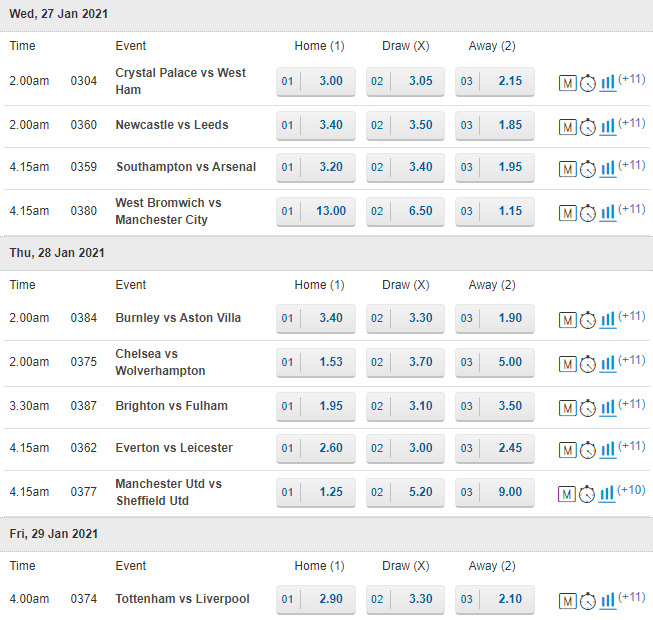

In [43]:
#Importing in Singapore Pools Odds
Image("images/sgp_odds_result.png")

Based on the odds table above, most of our odds are quite similar to Singapore Pool's. Most of the odds are close. It is just that one match or two matches are very different. An example will be match number 2, West Bromwich Albion Vs Manchester City. The odds for draw is higher than home win for us, whereas in Singapore Pools, their home win is 13 and draw is 6.50.

## Total Home Goals Prediction

We will be predicting the match result using the features which we have trained in our Notebook Part 4A. We have also imported the model in using pickle. We will generate the results first, after that compare to Singapore Pools Odds together with the Away Goals Prediction.

In [44]:
#Data to be predicted
to_be_predicted

date                                    match  \
185 2021-01-26         Newcastle_United_vs_Leeds_United   
186 2021-01-26        Crystal_Palace_vs_West_Ham_United   
187 2021-01-26  West_Bromwich_Albion_vs_Manchester_City   
188 2021-01-26                   Southampton_vs_Arsenal   
189 2021-01-27                   Burnley_vs_Aston_Villa   
190 2021-01-27                Everton_vs_Leicester_City   
191 2021-01-27       Chelsea_vs_Wolverhampton_Wanderers   
192 2021-01-27    Manchester_United_vs_Sheffield_United   
193 2021-01-27         Brighton_&_Hove_Albion_vs_Fulham   
194 2021-01-28           Tottenham_Hotspur_vs_Liverpool   

                       home                                 stadium  \
185        Newcastle United                          St.James' Park   
186          Crystal Palace                           Selhurst Park   
187    West Bromwich Albion                           The Hawthorns   
188             Southampton                      St. Mary's Stadium   
189                 Burnley                               Turf Moor   
190                 Everton                           Goodison Park   
191                 Chelsea                         Stamford Bridge   
192       Manchester United                            Old Trafford   
193  Brighton & Hove Albion  The American Express Community Stadium   
194       Tottenham Hotspur               Tottenham Hotspur Stadium   

    attendance  h_gls  h_ast  h_pk  h_pkatt  h_sh  h_sot  h_yellow  h_red  \
185          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
186          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
187          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
188          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
189          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
190          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
191          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
192          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
193          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   
194          0    0.0    0.0   0.0      0.0   0.0    0.0       0.0    0.0   

     h_touches  h_press  h_tkl  h_int  h_blk  h_xg  h_npxg  h_xa  h_sca  \
185        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
186        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
187        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
188        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
189        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
190        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
191        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
192        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
193        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   
194        0.0      0.0    0.0    0.0    0.0   0.0     0.0   0.0    0.0   

     h_gca  h_cmp  h_pass_att  h_pass_prog  h_carries  h_carries_prog  \
185    0.0    0.0         0.0          0.0        0.0             0.0   
186    0.0    0.0         0.0          0.0        0.0             0.0   
187    0.0    0.0         0.0          0.0        0.0             0.0   
188    0.0    0.0         0.0          0.0        0.0             0.0   
189    0.0    0.0         0.0          0.0        0.0             0.0   
190    0.0    0.0         0.0          0.0        0.0             0.0   
191    0.0    0.0         0.0          0.0        0.0             0.0   
192    0.0    0.0         0.0          0.0        0.0             0.0   
193    0.0    0.0         0.0          0.0        0.0             0.0   
194    0.0    0.0         0.0          0.0        0.0             0.0   

     h_dri_succ  h_dri_att  h_yellow2  h_fls  h_fld  h_off  h_crs  h_tklw  \
185         0.0        

In [45]:
#Features to be used
to_be_predicted_h_total_gls = to_be_predicted[['date', 'match', 'home', 'stadium', 'h_last_5_avrg_sh','h_last_5_avrg_sot', 'h_last_5_touches', 'h_last_5_avrg_blk',
               'h_last_5_avrg_xg', 'h_last_5_avrg_xa', 'h_last_5_avrg_sca','h_last_5_avrg_cmp', 'h_last_5_avrg_pass_att','h_last_5_avrg_pass_prog', 'h_last_5_avrg_carries',
                'h_last_5_avrg_carries_prog', 'h_last_5_avrg_fls','h_last_5_avrg_aer_lost', 'h_last_3_avrg_sh', 'h_last_3_avrg_sot', 'h_last_3_touches', 'h_last_3_avrg_blk', 'h_last_3_avrg_xg',
               'h_last_3_avrg_xa', 'h_last_3_avrg_sca', 'h_last_3_avrg_cmp','h_last_3_avrg_pass_att', 'h_last_3_avrg_pass_prog','h_last_3_avrg_carries', 'h_last_3_avrg_carries_prog', 'away',
               'a_last_5_avrg_gls', 'a_last_5_avrg_xg', 'a_last_5_avrg_gca','a_last_3_avrg_gls', 'a_last_3_avrg_gca', 'h_total_goals','h_total_value_eur', 'h_total_wage_eur', 'h_average_height_cm',
               'h_average_weight_kg', 'h_average_overall', 'h_average_potential','h_int_rep', 'h_skill_moves', 'h_int_repn_std', 'a_total_value_eur','a_total_wage_eur', 'a_average_overall',
               'a_average_potential', 'a_average_skill_moves']]

In [47]:
test_h_gls = to_be_predicted_h_total_gls.drop(columns = ['date','match','home','away','stadium','h_total_goals'])

In [48]:
#Scale the test set
test_h_gls_1 = home_goals_scaler.transform(test_h_gls)

In [49]:
#Getting the home total goals
h_test_preds = home_goals_production_model.predict(test_h_gls_1)
df_h_test_preds = pd.DataFrame(h_test_preds,columns = ['predicted home goals'])
#Getting the probability
h_test_proba = home_goals_production_model.predict_proba(test_h_gls_1)
df_h_test_prob = pd.DataFrame(h_test_proba)

In [61]:
#Table for probability and prediction outcome
h_matches_preds = pd.merge(to_be_predicted[['date','match','home','away']].reset_index(drop=True),df_h_test_preds,left_index=True,right_index=True)
h_matches_preds_proba = pd.merge(h_matches_preds.reset_index(drop=True),df_h_test_prob,left_index=True,right_index=True)
h_matches_preds_proba.head(1)

date                             match              home  \
0 2021-01-26  Newcastle_United_vs_Leeds_United  Newcastle United   

           away  predicted home goals         0         1         2         3  \
0  Leeds United                     2  0.146333  0.251213  0.496062  0.086157   

          4         5             6  
0  0.019816  0.000418  2.142927e-07

## Away Total Goals Prediction

In [51]:
to_be_predicted.head()

date                                    match                  home  \
185 2021-01-26         Newcastle_United_vs_Leeds_United      Newcastle United   
186 2021-01-26        Crystal_Palace_vs_West_Ham_United        Crystal Palace   
187 2021-01-26  West_Bromwich_Albion_vs_Manchester_City  West Bromwich Albion   
188 2021-01-26                   Southampton_vs_Arsenal           Southampton   
189 2021-01-27                   Burnley_vs_Aston_Villa               Burnley   

                stadium attendance  h_gls  h_ast  h_pk  h_pkatt  h_sh  h_sot  \
185      St.James' Park          0    0.0    0.0   0.0      0.0   0.0    0.0   
186       Selhurst Park          0    0.0    0.0   0.0      0.0   0.0    0.0   
187       The Hawthorns          0    0.0    0.0   0.0      0.0   0.0    0.0   
188  St. Mary's Stadium          0    0.0    0.0   0.0      0.0   0.0    0.0   
189           Turf Moor          0    0.0    0.0   0.0      0.0   0.0    0.0   

     h_yellow  h_red  h_touches  h_press  h_tkl  h_int  h_blk  h_xg  h_npxg  \
185       0.0    0.0        0.0      0.0    0.0    0.0    0.0   0.0     0.0   
186       0.0    0.0        0.0      0.0    0.0    0.0    0.0   0.0     0.0   
187       0.0    0.0        0.0      0.0    0.0    0.0    0.0   0.0     0.0   
188       0.0    0.0        0.0      0.0    0.0    0.0    0.0   0.0     0.0   
189       0.0    0.0        0.0      0.0    0.0    0.0    0.0   0.0     0.0   

     h_xa  h_sca  h_gca  h_cmp  h_pass_att  h_pass_prog  h_carries  \
185   0.0    0.0    0.0    0.0         0.0          0.0        0.0   
186   0.0    0.0    0.0    0.0         0.0          0.0        0.0   
187   0.0    0.0    0.0    0.0         0.0          0.0        0.0   
188   0.0    0.0    0.0    0.0         0.0          0.0        0.0   
189   0.0    0.0    0.0    0.0         0.0          0.0        0.0   

     h_carries_prog  h_dri_succ  h_dri_att  h_yellow2  h_fls  h_fld  h_off  \
185             0.0         0.0        0.0        0.0    0.0    0.0    0.0   
186             0.0         0.0        0.0        0.0    0.0    0.0    0.0   
187             0.0         0.0        0.0        0.0    0.0    0.0    0.0   
188             0.0         0.0        0.0        0.0    0.0    0.0    0.0   
189             0.0         0.0        0.0        0.0    0.0    0.0    0.0   

     h_crs  h_tklw  h_pkwon  h_pkcon  h_og  h_recov  h_aer_won  h_aer_lost  \
185    0.0     0.0      0.0      0.0   0.0      0.0        0.0         0.0   
186    0.0     0.0      0.0      0.0   0.0      0.0        0.0         0.0   
187    0.0     0.0      0.0      0.0   0.0      0.0        0.0         0.0   
188    0.0     0.0      0.0      0.0   0.0      0.0        0.0         0.0   
189    0.0     0.0      0.0      0.0   0.0      0.0        0.0         0.0   

     h_last_5_avrg_gls  h_last_5_avrg_ast  h_last_5_avrg_pk  \
185                0.8                0.4               0.2   
186                1.6                1.2               0.2   
187                1.0                0.4               0.4   
188                1.6                1.2               0.2   
189                0.4                0.0               0.2   

     h_last_5_avrg_pkatt  h_last_5_avrg_sh  h_last_5_avrg_sot  \
185                  0.2               7.4                2.0   
186                  0.2              10.4                3.2   
187                  0.4              10.4                2.8   
188                  0.2              11.4                4.6   
189                  0.2               8.6                2.6   

     h_last_5_avrg_yellow  h_last_5_avrg_red  h_last_5_touches  \
185                   2.8                0.2             483.2   
186                   1.6                0.4             529.4   
187                   1.2                0.0             485.0   
188                   1.8                0.0             667.4   
189                   1.4                0.0             515.2   

     h_last_5_avrg_press  h_last_5_avrg_t

In [52]:
#Features to be used for away predictions
to_be_predicted_a_total_gls = to_be_predicted[['date', 'match', 'home', 'stadium', 'h_last_5_avrg_sh', 'h_last_5_avrg_sot', 'h_last_5_touches', 'h_last_5_avrg_xa','h_last_5_avrg_sca', 'h_last_5_avrg_cmp', 'h_last_5_avrg_pass_att',
                                               'h_last_5_avrg_pass_prog', 'h_last_5_avrg_carries','h_last_5_avrg_carries_prog', 'h_last_3_touches', 'h_last_3_avrg_cmp','h_last_3_avrg_pass_att', 'h_last_3_avrg_carries',
                                               'h_last_3_avrg_carries_prog', 'away', 'a_last_5_avrg_gls','a_last_5_avrg_sh', 'a_last_5_avrg_sot', 'a_last_5_touches','a_last_5_avrg_xg', 'a_last_5_avrg_xa', 'a_last_5_avrg_sca',
                                               'a_last_5_avrg_gca', 'a_last_5_avrg_cmp', 'a_last_5_avrg_pass_att','a_last_5_avrg_pass_prog', 'a_last_5_avrg_carries','a_last_5_avrg_carries_prog', 'a_last_3_avrg_sh', 'a_last_3_avrg_sot',
                                               'a_last_3_touches', 'a_last_3_avrg_xg', 'a_last_3_avrg_sca','a_last_3_avrg_cmp', 'a_last_3_avrg_pass_att', 'a_last_3_avrg_carries','h_total_value_eur', 'h_total_wage_eur', 'h_average_overall',
                                               'h_average_potential', 'h_int_rep', 'h_int_repn_std','a_total_value_eur', 'a_total_wage_eur', 'a_average_overall','a_average_potential', 'a_average_int_rep', 'a_int_rep_std']]

In [53]:
#Drop date,match,home,away,stadium
test_a_gls = to_be_predicted_a_total_gls.drop(columns = ['date','match','home','away','stadium'])

In [54]:
#Scale the test set
test_a_gls_1 = away_goals_scaler.transform(test_a_gls)

In [55]:
#Getting the home total goals
a_test_preds = away_goals_production_model.predict(test_a_gls_1)
df_a_test_preds = pd.DataFrame(a_test_preds,columns = ['predicted away goals'])
#Getting the probability
a_test_proba = away_goals_production_model.predict_proba(test_a_gls_1)
df_a_test_prob = pd.DataFrame(a_test_proba)

In [62]:
#Table for probability and prediction outcome
a_matches_preds = pd.merge(to_be_predicted[['date','match','home','away']].reset_index(drop=True),df_a_test_preds,left_index=True,right_index=True)
a_matches_preds_proba = pd.merge(a_matches_preds.reset_index(drop=True),df_a_test_prob,left_index=True,right_index=True)
a_matches_preds_proba.tail()

date                                  match                    home  \
5 2021-01-27              Everton_vs_Leicester_City                 Everton   
6 2021-01-27     Chelsea_vs_Wolverhampton_Wanderers                 Chelsea   
7 2021-01-27  Manchester_United_vs_Sheffield_United       Manchester United   
8 2021-01-27       Brighton_&_Hove_Albion_vs_Fulham  Brighton & Hove Albion   
9 2021-01-28         Tottenham_Hotspur_vs_Liverpool       Tottenham Hotspur   

                      away  predicted away goals         0         1  \
5           Leicester City                     1  0.234397  0.307467   
6  Wolverhampton Wanderers                     1  0.382394  0.369071   
7         Sheffield United                     0  0.485966  0.331751   
8                   Fulham                     0  0.414615  0.262282   
9                Liverpool                     1  0.257263  0.300202   

          2         3         4         5         6  
5  0.210535  0.208931  0.034625  0.003232  0.000813  
6  0.177739  0.063230  0.007194  0.000225  0.000148  
7  0.158836  0.022107  0.000859  0.000264  0.000217  
8  0.202178  0.106686  0.010863  0.003207  0.000169  
9  0.247653  0.189179  0.002346  0.000516  0.002841

## Getting Odds For Comparison with Singapore Pools for Home & Away Total Goals

In [57]:
#Home Goal Odds 
h_odds_result = h_matches_preds_proba[[0,1,2,3,4,5,6]].rdiv(1)
h_matches_preds_odds = pd.merge(h_matches_preds.reset_index(drop=True),round(h_odds_result,2),left_index=True,right_index=True)
spurs_liverpool = h_matches_preds_odds.tail(1)

In [58]:
#Away Goal Odds
a_odds_result = a_matches_preds_proba[[0,1,2,3,4,5,6]].rdiv(1)
a_matches_preds_odds = pd.merge(a_matches_preds.reset_index(drop=True),round(a_odds_result,2),left_index=True,right_index=True)

In [59]:
spurs_liverpool.append(a_matches_preds_odds.tail(1))

date                           match               home       away  \
9 2021-01-28  Tottenham_Hotspur_vs_Liverpool  Tottenham Hotspur  Liverpool   
9 2021-01-28  Tottenham_Hotspur_vs_Liverpool  Tottenham Hotspur  Liverpool   

   predicted home goals     0     1     2      3       4        5           6  \
9                   2.0  4.53  4.13  2.27  12.46  207.42    83.34  3707662.94   
9                   NaN  3.89  3.33  4.04   5.29  426.23  1939.09      351.94   

   predicted away goals  
9                   NaN  
9                   1.0

Based on the home and away goals predictions on Tottenham Hotspur vs Liverpool, there will be 2 home goals and 1 away goal. Total goal will be 3 goals. 

Based on the total goals odds below, the lowest odds is 2 goals which is 3.3 and 2nd lowest is 3 goals which is 3.5. It means that our prediction is quite close to the score that likely to happen.

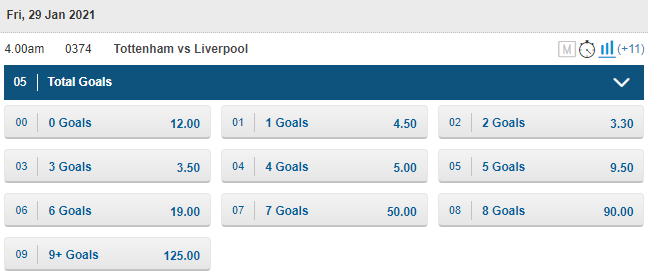

In [60]:
#Importing in Singapore Pools Odds
Image("images/totalgoals_odds.png")

# Conclusion



Using the data and Random Forest Classifier, we are only able to get 53% accuracy and F1-Score for the result prediction. Additionally, for home and away goals predictions,we are only able to get 31.2% by using Gradient Boosting and 32.2% by using Support Vector Classifier. Both of the scores are lower than the baseline. 

Despite only getting 50% accuracy, it might not be a bad thing as there is more than 50% chance to getting the right result. However, football prediction is not as easy as it seems to be. There are other factors that might come into play and affect the final result, even if we have all the data necessary and able to predict 100%. Other factors include match-fixing, players injuries, match postponement, fatigue, etc.

For the future, I will like to get more data like events during a match, such as a shot on target at 30 min, or a goal by home team at 40 min before half time, or after half time. Other data includes more players data or player-to-player data. With these data, I will be able to explore on more other targets such as halftime and full time scores, which team to score first, which player to score first, number of corners, number of yellow cards and etc.
